In [1]:
from collections import defaultdict
import numpy as np
import tabulation
from tabulation import Lifetimes
from tabulation import IMF
from scipy import integrate
from tqdm import tqdm_notebook as tqdm

import betterplotlib as bpl
bpl.presentation_style()

In [2]:
import sys, os
sys.path.append(os.path.abspath("../../"))

For some unknown reason we need to import numpy before my elements. Doing that must add some things to the path that my code here needs somehow?

I won't bother with the elements vs no elements thing, since that gets taken care of during runtime when adding things to cells. I'll only worry about continuous vs discrete. All other things have been tested to be the same under all other conditions.

In [3]:
from core_enrich_ia_elts_cluster_discrete import lib as core
from snia_enrich_ia_elts_cluster_discrete import lib as snia_discrete
from snia_enrich_ia_elts_cluster          import lib as snia_continuous
from snii_enrich_ia_elts_cluster_discrete import lib as snii_discrete
from snii_enrich_ia_elts_cluster          import lib as snii_continuous
from agb_enrich_ia_elts_cluster_discrete  import lib as agb
from wind_enrich_ia_elts_cluster_discrete import lib as winds

In [4]:
core.detailed_enrichment_init()
snia_discrete.detailed_enrichment_init()
snia_continuous.detailed_enrichment_init()
snii_discrete.detailed_enrichment_init()
snii_discrete.init_rand()
snii_continuous.detailed_enrichment_init()
agb.detailed_enrichment_init()
winds.detailed_enrichment_init()

In [5]:
bpl.presentation_style()

In [6]:
def art_mass_loss_rate(age, m_star):
    if (age > 2.75423e6):
        return m_star * (0.12486-3.89635e-3*np.log(age)) / age 
    else:
        return 0

In [7]:
lt = Lifetimes("Raiteri_96")
imf = IMF("Kroupa", 0.08, 50, total_mass=1)

First try to see if the integration is okay.

In [8]:

# frac_N_SN = 0.0109743508039993  # SN / solar mass

In [9]:
frac_N_SN_II = integrate.quad(imf.normalized_dn_dm, 8.0, 50.0)[0]

In [10]:
integrate.quad(imf.normalized_dn_dm, 0.08, 50.0)[0]

1.8195539821139628

In [11]:
core.imf_integral_py(0.08, 50.0)

1.8195539834437708

In [12]:
frac_N_SN_Ia = 1.6E-3

In [13]:
for _ in range(100):
    m_low, m_high = sorted(np.random.uniform(0.1, 0.9, 2))
    
    int_1 = integrate.quad(imf.normalized_dn_dm, m_low, m_high)[0]
    int_2 = core.imf_integral_py(m_low, m_high)
    
    if abs(int_1/int_2 - 1.0) > 0.01:
        print("{:.3f} {:.3f}\n{:.10f}\n{:.10}\n{:.10f}".format(m_low, m_high, int_1, int_2, int_1 / int_2))
        print("----")

In [14]:
for _ in range(100):
    m_low, m_high = sorted(np.random.uniform(0.1, 50.0, 2))
    
    int_1 = integrate.quad(imf.normalized_dn_dm, m_low, m_high)[0]
    int_2 = core.imf_integral_py(m_low, m_high)
    if abs(int_1/int_2 - 1.0) > 0.01:
        print("{:.1f} {:.1f}\n{:.10f}\n{:.10}\n{:.10f}".format(m_low, m_high, int_1, int_2, int_1 / int_2))
        print("----")

Figure out what to expect for the SN history

In [15]:
ssp_art = tabulation.SSPYields("Kroupa", 0.08, 50, 1,
                               "Raiteri_96", 
                               "Kobayashi_06", 0.5, 8, 50,
                               "art power law", "Nomoto_18", {"number_sn_ia":0.0016},
                               "NuGrid", 0.08, 8)

In [16]:
frac_E = ssp_art.energy_erg_yr_supernovae(1E6, 1E8, 0.02) * 1E8  # ergs / solar mass

Then attempt to build a SN history

In [17]:
def ceil_to_nearest(num, scale):
    test_values = np.arange(0, num+2*scale, scale)
    for val in test_values:
        if val - scale > num:
            return val

In [18]:
dt_sn = 1E5
dt_agb = 1E7

In [19]:
times = dict()
turnoff_masses = dict()
def generate_times(zs):
    for z in zs:
        split = ceil_to_nearest(lt.lifetime(8.0, z), dt_sn)
        times[z] = np.concatenate([np.arange(0, split, dt_sn),
                                   np.arange(split, 14E9, dt_agb)])
        turnoff_masses[z] = [lt.turnoff_mass(t, z) for t in tqdm(times[z])]

In [20]:
generate_times([0.02, 0.01, 0.004, 0.001, 0.0005, 0.0001])

In [21]:
solar_metallicities = {"Z":0.02, "C":2.78E-3, "N":8.14E-4, "O":7.56E-3,
                       "Mg":6.45E-4, "S":4.79E-4, "Ca":6.41E-5, "Fe":1.23E-3}

In [22]:
elts = ["C", "N", "O", "Mg", "S", "Ca", "Fe"]
all_fields = elts + ["Z_II", "Z_Ia", "Z_AGB", "Z", "total", "E", "N_SN", "N_SN_left"]
sn_ii_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
              "Z_II": 7, "Z": 7, "total": 8, "E": 9, "N_SN": 10, "N_SN_left": 11}
agb_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
           "Z_AGB": 7, "Z": 7, "total":8}
sn_ia_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
              "Z_Ia": 7, "Z": 7, "total": 7, "E": 8, "N_SN_left": 9}
# The raw yields doesn't return some elements, since those are scaled based on
# the metallicity of the star
agb_idxs_yields = {"C": 0, "N": 1, "O":2, "Mg":3, "Z_AGB":4, "total": 5}

class SNHistory(object):
    def __init__(self, stellar_mass, z, discrete=True, verbose=False):
        self.mass = stellar_mass
        self.z = z
        
        self.age_50 = lt.lifetime(50.0, self.z)
        
        self.times = times[z]
        self.turnoff_masses = turnoff_masses[z]
        
        self.discrete = discrete
        
        # handle which functions to call
        if discrete:
            self.sn_ii_func = snii_discrete.get_ejecta_sn_ii_py
            self.sn_ia_func = snia_discrete.sn_ia_core_py
        else:
            self.sn_ii_func = snii_continuous.get_ejecta_sn_ii_py
            self.sn_ia_func = snia_continuous.sn_ia_core_py
        
        self.sn_ia_start = lt.lifetime(8.0, self.z)
        
        self.yields = defaultdict(list)
        self.cumulative = defaultdict(list)
        
        self.yields_sn_ii = defaultdict(list)
        self.cumulative_sn_ii = defaultdict(list)
        
        self.yields_sn_ia = defaultdict(list)
        self.cumulative_sn_ia = defaultdict(list)
        
        self.yields_agb = defaultdict(list)
        self.cumulative_agb = defaultdict(list)
        
        self.yields_winds = defaultdict(list)
        self.cumulative_winds = defaultdict(list)
        
        self.handle_history(verbose)
        
    def handle_history(self, verbose=False):
        self.unexploded_sn_ii = 0
        self.unexploded_sn_ia = 0
        
        for idx in range(len(self.turnoff_masses) - 1):
            m_now  = self.turnoff_masses[idx]
            m_next = self.turnoff_masses[idx+1]
            age_now = self.times[idx]
            age_next = self.times[idx+1]
            dt = age_next - age_now
            sn_ii_yields = self.sn_ii_func(self.unexploded_sn_ii, m_now, m_next, self.mass, self.z)
            agb_yields = agb.get_ejecta_agb_py(m_now, m_next, self.mass, self.z,
                                               (self.z/0.02) * solar_metallicities["S"],
                                               (self.z/0.02) * solar_metallicities["Ca"],
                                               (self.z/0.02) * solar_metallicities["Fe"])
            sn_ia_yields = self.sn_ia_func(self.unexploded_sn_ia, age_now, dt,
                                           self.mass, self.z, self.sn_ia_start)
            winds_yields = winds.get_ejecta_winds_py(age_now, age_next, 
                                                     m_now, m_next, 
                                                     self.mass, self.z, self.age_50)
            
            # handle SN numbers
            if self.discrete:
                self.unexploded_sn_ii = sn_ii_yields[sn_ii_idxs["N_SN_left"]]
                self.unexploded_sn_ia = sn_ia_yields[sn_ia_idxs["N_SN_left"]]
#             print(m_now, m_next, yields[self.idxs["N_SN"]], self.unexploded_sn)
            if verbose:
                print("{:8.4f} {:8.4f} {:8.4f} {:8.4f}".format(m_now, m_next, sn_ii_yields[sn_ii_idxs["N_SN"]], self.unexploded_sn))
            
            for field in all_fields:
                if field in sn_ii_idxs:
                    this_sn_ii_yield = sn_ii_yields[sn_ii_idxs[field]]
                else:
                    this_sn_ii_yield = 0
                    
                if field in sn_ia_idxs:
                    this_sn_ia_yield = sn_ia_yields[sn_ia_idxs[field]]
                elif field == "N_SN":
                    this_sn_ia_yield = sn_ia_yields[sn_ia_idxs["E"]] / 2E51
                else:
                    this_sn_ia_yield = 0
                    
                
                if field in agb_idxs:
                    this_agb_yield = agb_yields[agb_idxs[field]]
                else:
                    this_agb_yield = 0
                    
                if field == "total":
                    this_wind_yield = winds_yields
                elif field in elts:
                    this_wind_yield = winds_yields * (self.z/0.02) * solar_metallicities[field]
                else:
                    this_wind_yield = 0
                
                total_yield = this_sn_ii_yield + this_sn_ia_yield + this_agb_yield + this_wind_yield
                
                self.yields_sn_ii[field].append(this_sn_ii_yield / dt)
                self.yields_sn_ia[field].append(this_sn_ia_yield / dt)
                self.yields_agb[field].append(this_agb_yield / dt)
                self.yields_winds[field].append(this_wind_yield / dt)
                self.yields[field].append(total_yield / dt)
                
                if len(self.cumulative[field]) == 0:
                    self.cumulative[field].append(total_yield)
                else:
                    self.cumulative[field].append(self.cumulative[field][-1] + total_yield)
                    
                if len(self.cumulative_sn_ii[field]) == 0:
                    self.cumulative_sn_ii[field].append(this_sn_ii_yield)
                else:
                    self.cumulative_sn_ii[field].append(self.cumulative_sn_ii[field][-1] + this_sn_ii_yield)
                    
                if len(self.cumulative_sn_ia[field]) == 0:
                    self.cumulative_sn_ia[field].append(this_sn_ia_yield)
                else:
                    self.cumulative_sn_ia[field].append(self.cumulative_sn_ia[field][-1] + this_sn_ia_yield)
                    
                if len(self.cumulative_agb[field]) == 0:
                    self.cumulative_agb[field].append(this_agb_yield)
                else:
                    self.cumulative_agb[field].append(self.cumulative_agb[field][-1] + this_agb_yield)
                    
                if len(self.cumulative_winds[field]) == 0:
                    self.cumulative_winds[field].append(this_wind_yield)
                else:
                    self.cumulative_winds[field].append(self.cumulative_winds[field][-1] + this_wind_yield)
        

In [23]:
def plot_history(field, mass, z, verbose=False):
    plot_times = times[z][1:]
    fig, ax = bpl.subplots()
    
    left_limit = 1E6
    right_limit = max(plot_times)
    
    ax.set_xscale("log")
#     if field not in ["N_SN"]:
#         ax.set_yscale("log")
    if field == "E":
        label = "E [ergs] Cumulative"
    elif field =="N_SN":
        label = "Number of Supernovae"
    else: 
        label = "Cumulative " + field + " Ejecta [$M_\odot$]"
    ax.add_labels("Age [yr]", label)
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "} M_\odot$" + "\nZ = {}".format(z), 
                     "upper left")
    
    if field == "E":
        ax.axhline(frac_E * mass, ls=":")
    if field == "N_SN":
        expected_ii = frac_N_SN_II * mass
        expected_ia = frac_N_SN_Ia * mass
        ax.axhline(expected_ii, ls=":")
        ax.axhline(expected_ia, ls=":")
        ax.add_text(left_limit, expected_ii, "{:.3f}".format(expected_ii), 
                    ha="left", va="bottom", fontsize=13)
        ax.add_text(left_limit, expected_ia, "{:.3f}".format(expected_ia), 
                    ha="left", va="bottom", fontsize=13)
    if field == "total":
        art_rates = [art_mass_loss_rate(t, mass) for t in plot_times]
        art_cumulative = integrate.cumtrapz(x=plot_times, y=art_rates, initial=0)
        ax.plot(plot_times, art_cumulative, label="Old ART", c=bpl.almost_black)
    
    for label in ["Continuous", "Discrete"]:
        discrete = label == "Discrete"
        if discrete:
            lw = 2
        else:
            lw = 4
        this_obj = SNHistory(mass, z, discrete, verbose)
        ax.plot(plot_times, this_obj.cumulative[field], lw=lw, label="Total " + label)
        ax.plot(plot_times, this_obj.cumulative_sn_ii[field], lw=lw, label="SN II " + label)
        ax.plot(plot_times, this_obj.cumulative_sn_ia[field], lw=lw, label="SN Ia " + label)
        
    if field != "N_SN":
        ax.plot(plot_times, this_obj.cumulative_agb[field], lw=lw, label="AGB")
        ax.plot(plot_times, this_obj.cumulative_winds[field], lw=lw, label="Winds")
    
    if field == "N_SN":  
        true_sn_ii = this_obj.cumulative_sn_ii[field][-1]
        ax.add_text(right_limit, true_sn_ii, "{:.3f}".format(true_sn_ii), 
                    ha="right", va="bottom", fontsize=13)

        true_sn_ia = this_obj.cumulative_sn_ia[field][-1]
        ax.add_text(right_limit, true_sn_ia, "{:.3f}".format(true_sn_ia), 
                    ha="right", va="bottom", fontsize=13)

    ax.legend(loc=6, frameon=False)
    
        
    ax.set_limits(left_limit, right_limit, 0)
    fig.savefig("../plots/discrete_{}_m_{:.1e}_dt_{:.1g}_z_{:.5f}.png".format(field, mass, dt_sn, z))
    
    return fig, ax

In [24]:
def plot_history_energy(mass, z, n):
    plot_times = times[z][1:]
    fig, ax = bpl.subplots()
    
    left_limit = 1E6
    right_limit = max(plot_times)
    
    ax.set_xscale("log")
    ax.add_labels("Age [yr]", "E [ergs] Cumulative")
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "} M_\odot$" + "\nZ = {}".format(z), 
                     "upper left")
    
    ax.axhline(frac_E * mass, ls=":")
    
    for i in range(n):
        c = bpl.color_cycle[i]
        if i == 0:
            label_total = "Total"
            label_ii = "SN II"
            label_ia = "SN Ia"
        else:
            label_total = None
            label_ii = None
            label_ia = None
        
        for label in ["Continuous", "Discrete"]:
            discrete = label == "Discrete"
            if discrete:
                lw = 2
            else:
                lw = 4
            this_obj = SNHistory(mass, z, discrete, False)
            ax.plot(plot_times, this_obj.cumulative["E"], c=c, ls="-", lw=lw, label=label_total)
            ax.plot(plot_times, this_obj.cumulative_sn_ii["E"], c=c, ls=":", lw=lw, label=label_ii)
            ax.plot(plot_times, this_obj.cumulative_sn_ia["E"], c=c, ls="--", lw=lw, label=label_ia)
            
    ax.legend()
        
    ax.set_limits(left_limit, right_limit, 0)
    fig.savefig("../plots/discrete_E_m_{:.1e}_dt_{:.1g}_z_{:.5f}.png".format(mass, dt_sn, z))
    
    return fig, ax

In [25]:
def plot_rates(field, mass, z):
    plot_times = times[z][1:]
    fig, ax = bpl.subplots()
    
    ax.set_xscale("log")
#     if field not in ["N_SN"]:
#         ax.set_yscale("log")
    ax.add_labels("Age [yr]", field + " Per Year")
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "}$", "lower right")
    
    for label in ["Continuous", "Discrete"]:
        discrete = label == "Discrete"
        if discrete:
            lw = 2
        else:
            lw = 4
        this_obj = SNHistory(mass, z, discrete)
        
        if field == "N_SN_left":
            ax.plot(plot_times, np.array(this_obj.yields[field]) * dt_sn, lw=lw, label="Total " + label)
            ax.plot(plot_times, np.array(this_obj.yields_sn_ii[field]) * dt_sn, lw=lw, label="SN II " + label)
            ax.plot(plot_times, np.array(this_obj.yields_sn_ia[field]) * dt_sn, lw=lw, label="SN Ia " + label)
        else:
            ax.plot(plot_times, this_obj.yields[field], lw=lw, label="Total " + label)
            ax.plot(plot_times, this_obj.yields_sn_ii[field], lw=lw, label="SN II " + label)
            ax.plot(plot_times, this_obj.yields_sn_ia[field], lw=lw, label="SN Ia " + label)
        
    if field != "N_SN":
        ax.plot(plot_times, this_obj.yields_agb[field], label="AGB " + label)
        ax.plot(plot_times, this_obj.yields_winds[field], label="Winds " + label)
#     else:
#         rates = [snia_discrete.get_sn_ia_rate_py(t, lt.lifetime(8.0, z))*mass for t in plot_times]
#         ax.plot(plot_times, rates, label='SN Ia rate', ls=":")
            
    if field == "total":
        art_rates = [art_mass_loss_rate(t, mass) for t in plot_times]
        ax.plot(plot_times, art_rates, label="Old ART", zorder=100, c=bpl.almost_black)

    ax.set_limits(1E6, max(plot_times), 0)
    ax.axvline(lt.lifetime(8.0, z), ls=":")
    ax.legend()
    
    return fig, ax

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


(<Figure size 1000x700 with 1 Axes>,
 <matplotlib.axes._subplots.Axes_bplSubplot at 0x1a18c9c7f0>)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


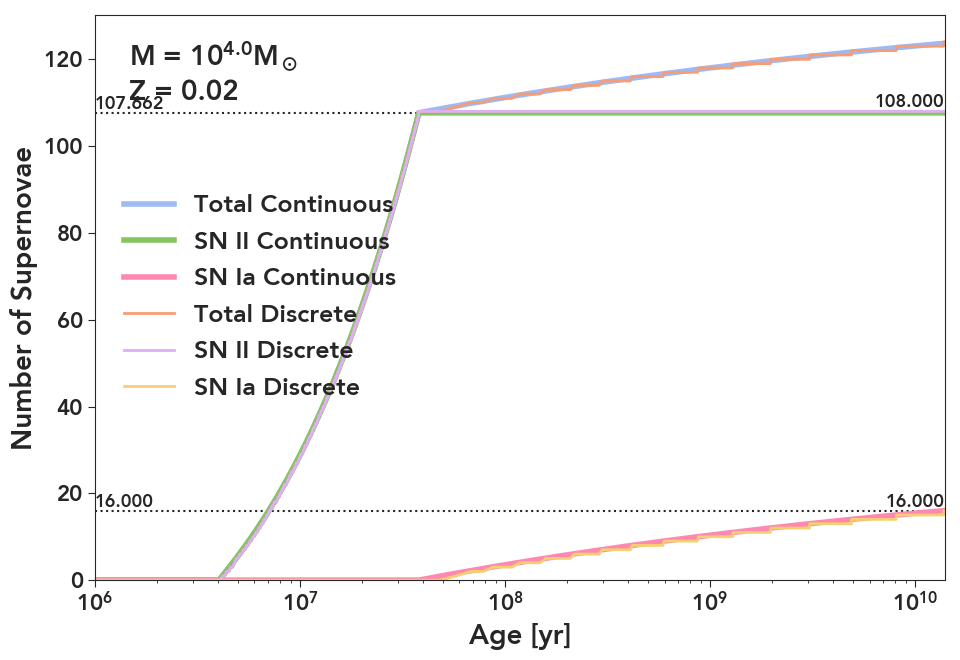

In [26]:
plot_history("N_SN", 10000, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


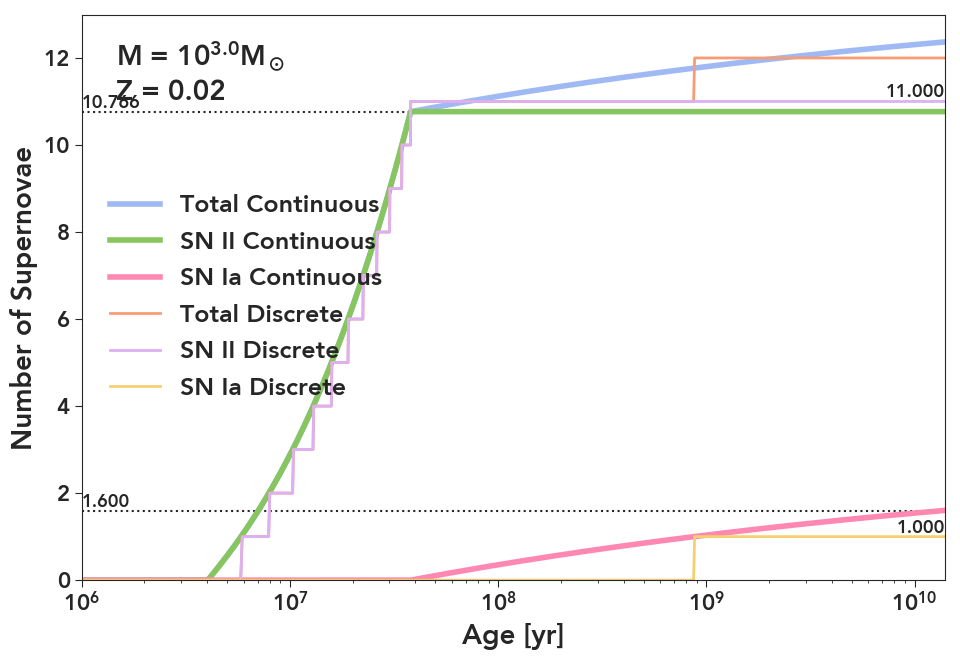

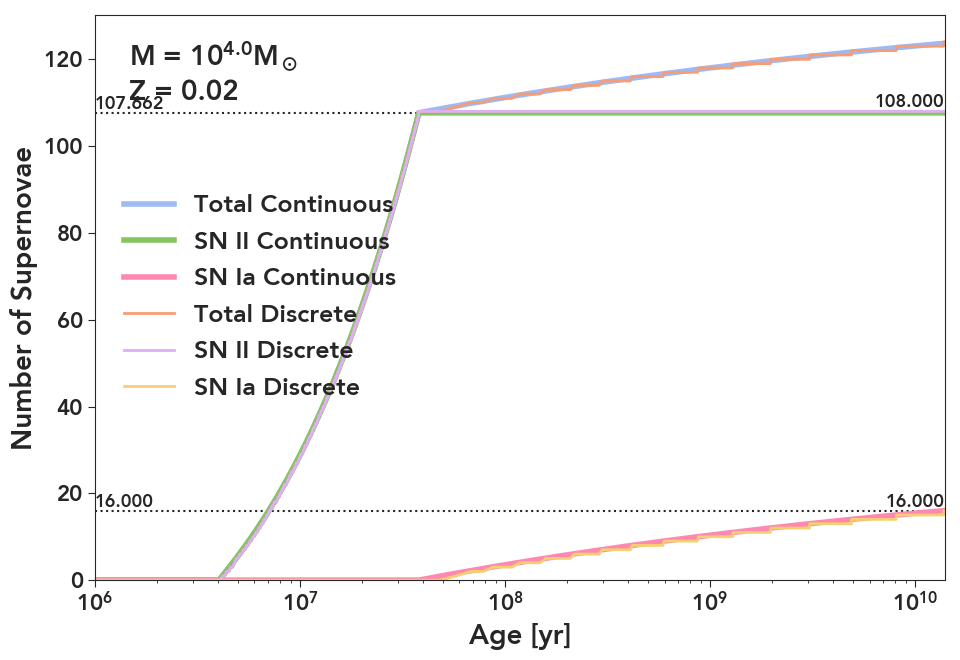

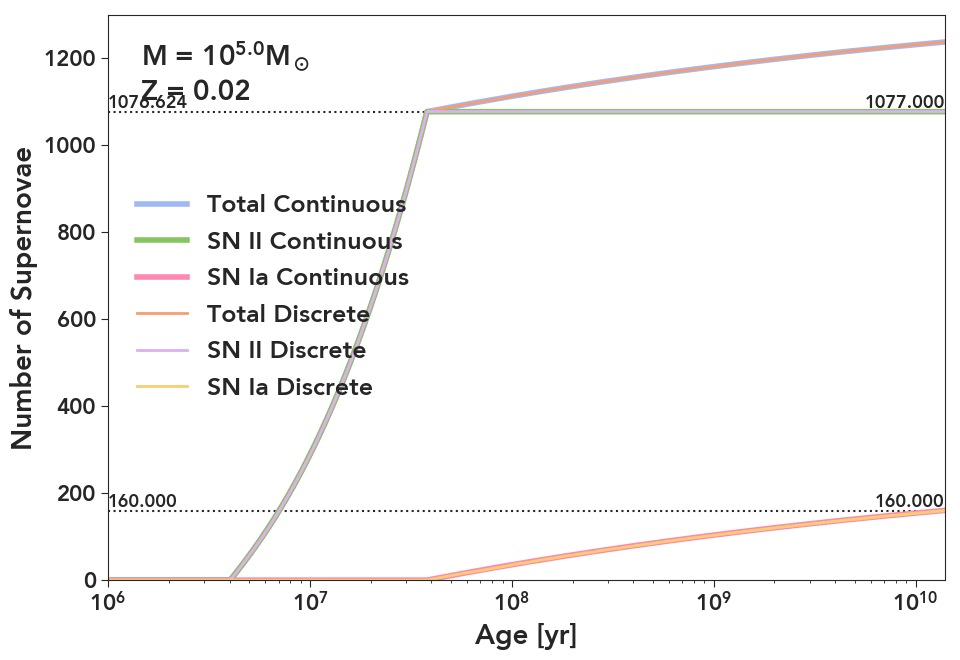

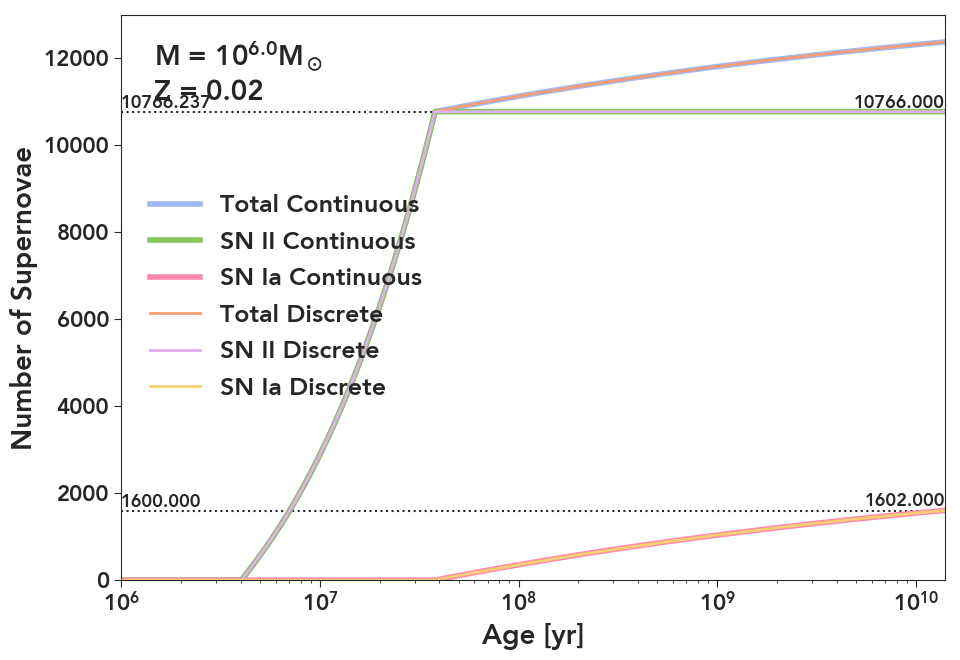

In [27]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("N_SN", m, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


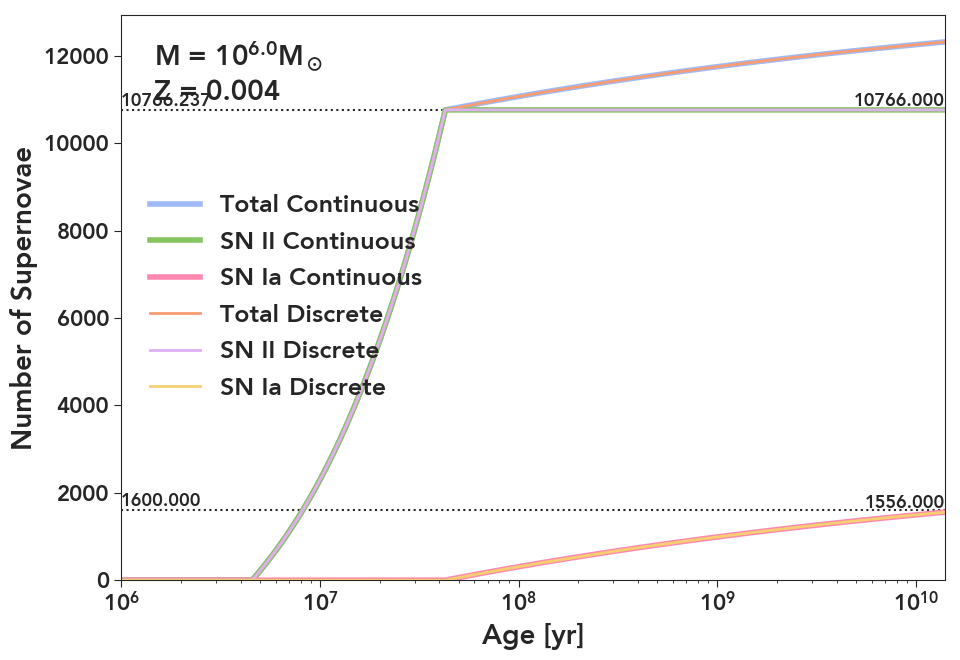

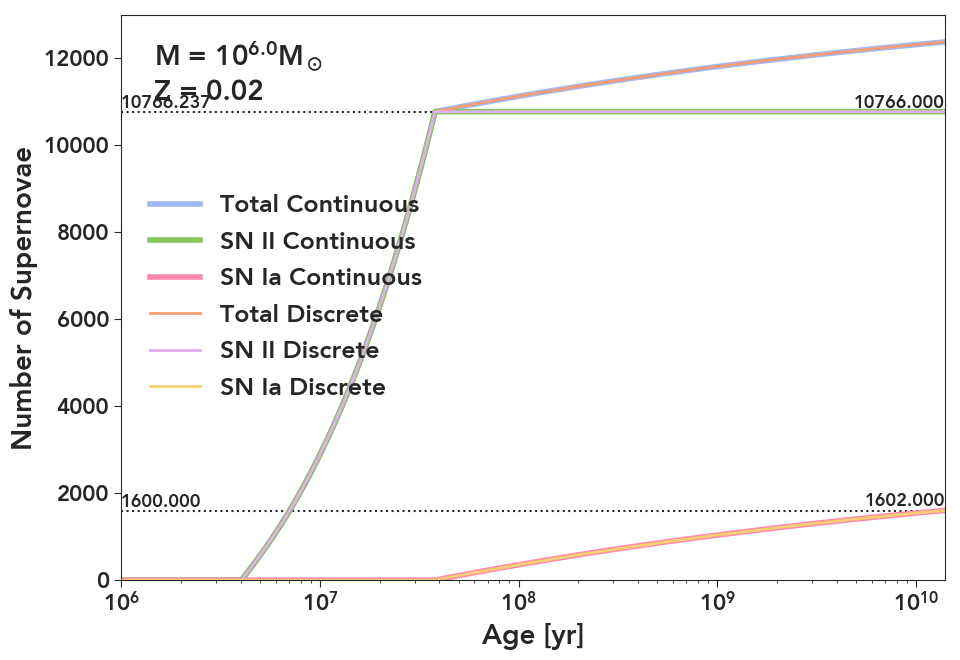

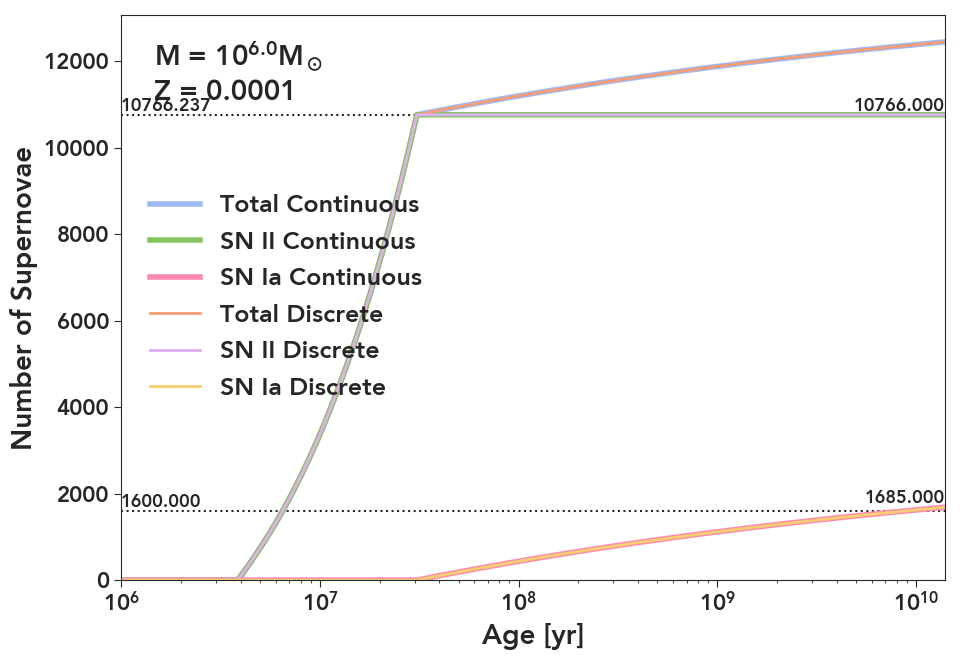

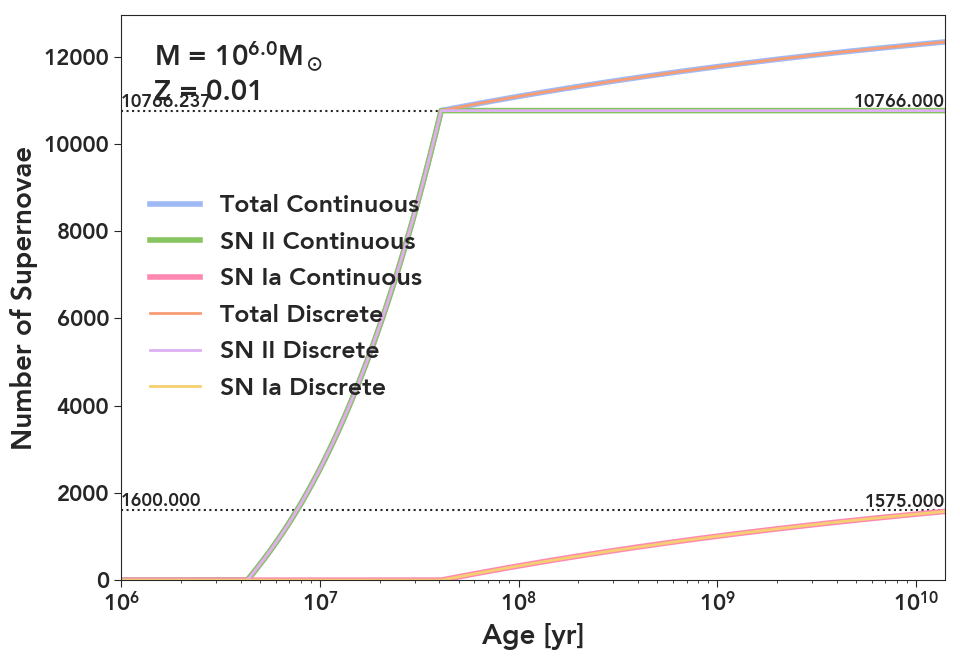

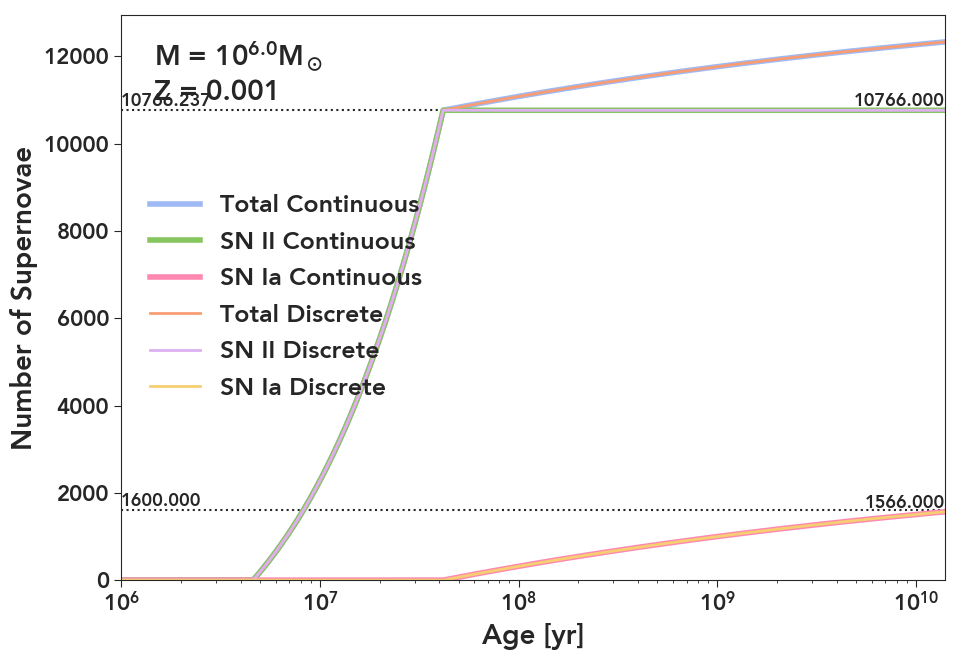

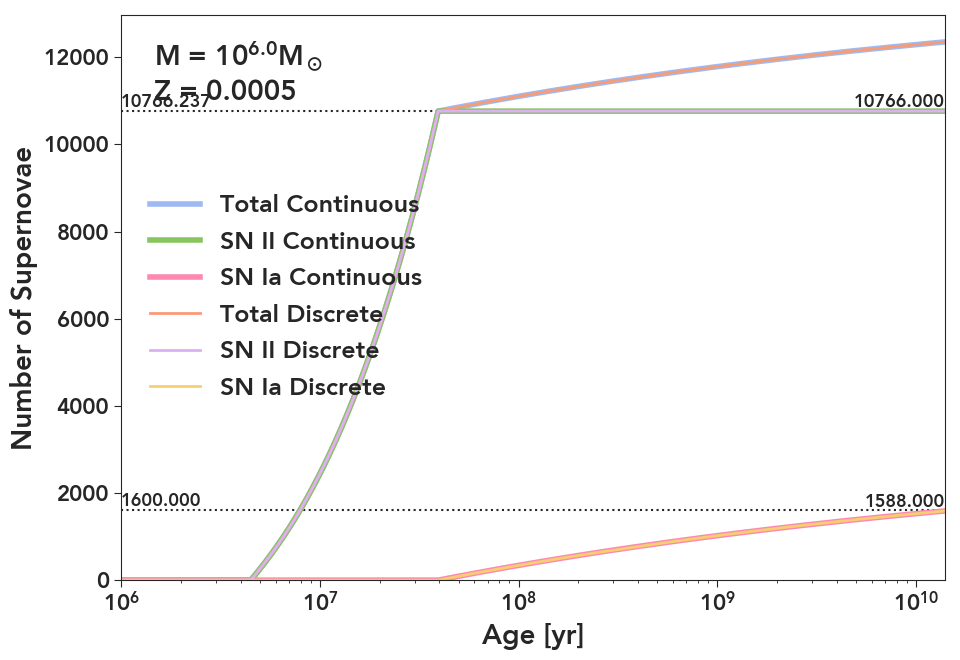

In [28]:
for z in times:
    plot_history("N_SN", 1E6, z)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


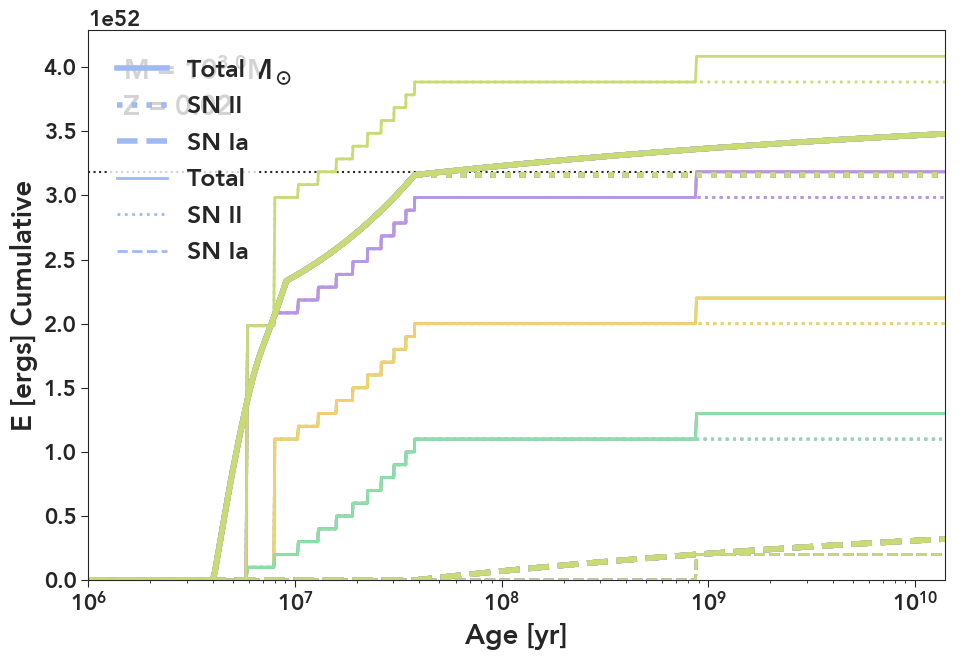

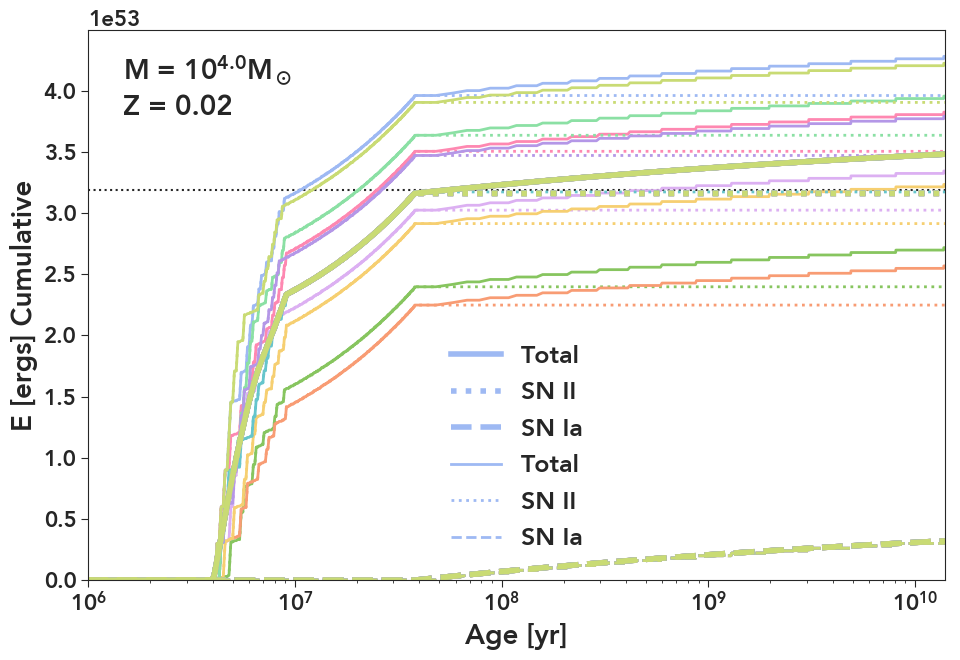

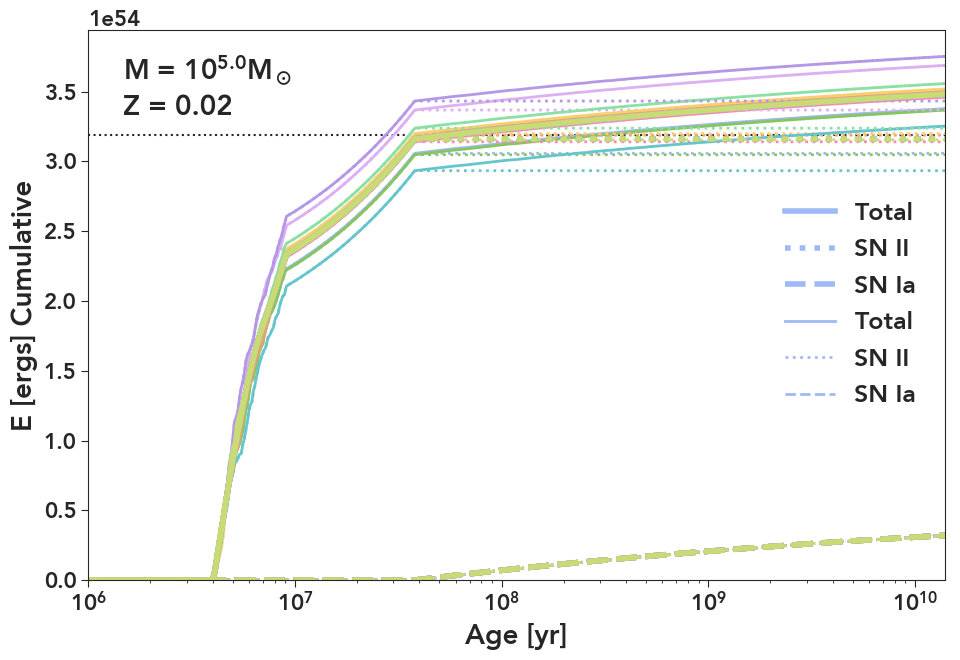

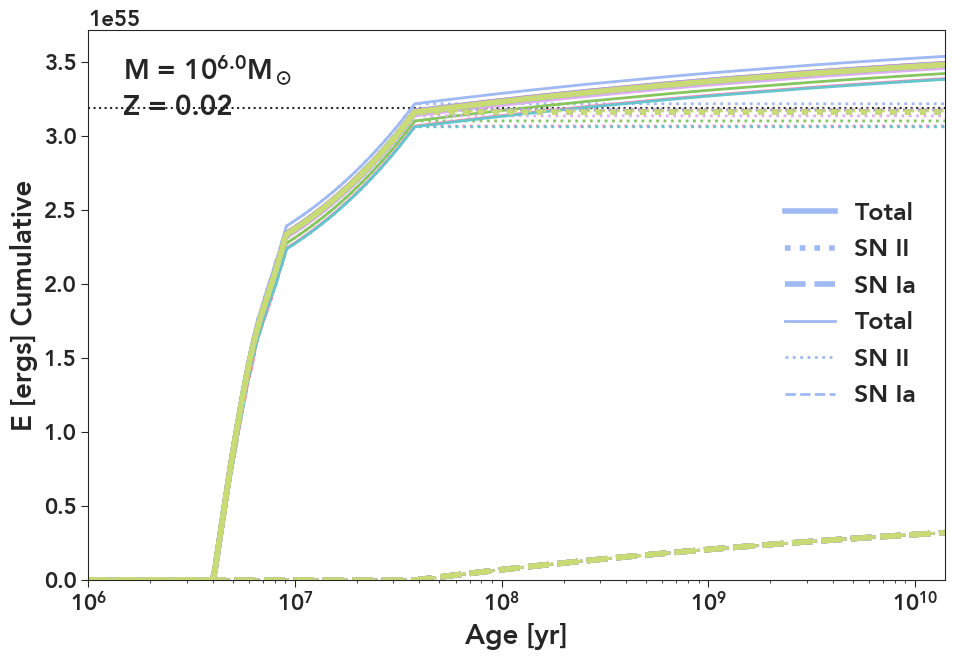

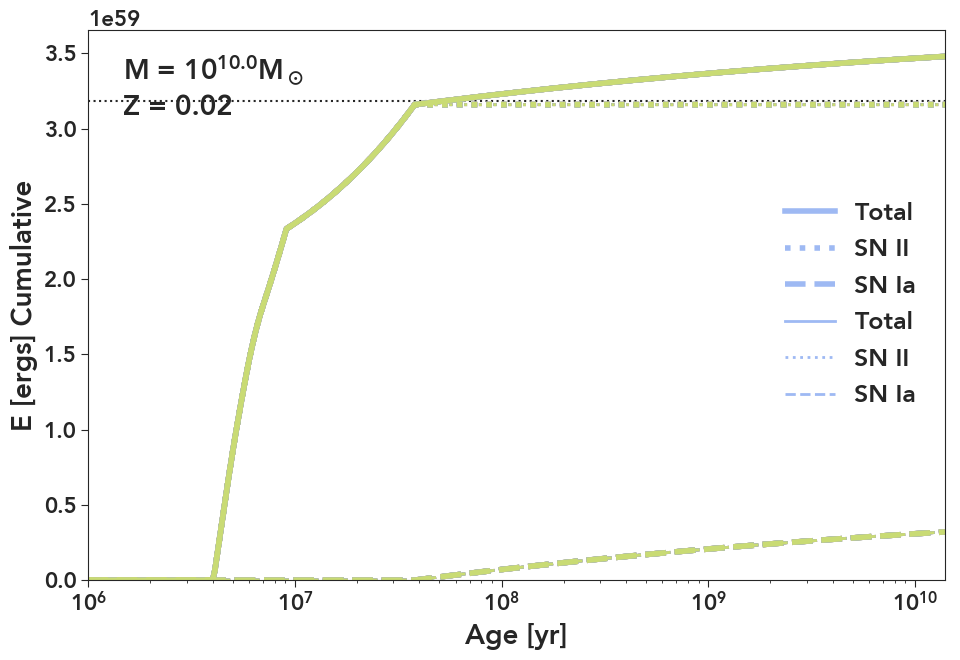

In [29]:
for m in [1E3, 1E4, 1E5, 1E6, 1E10]:
    plot_history_energy(m, 0.02, 10)

The energy here seems a bit off. Let's check

In [30]:
m_test = 1E6
print(frac_E * m_test)
this_obj = SNHistory(m_test, 0.01, False, False)
print(this_obj.cumulative["E"][-1])

3.1862716460039605e+55
3.4766857576992474e+55


/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


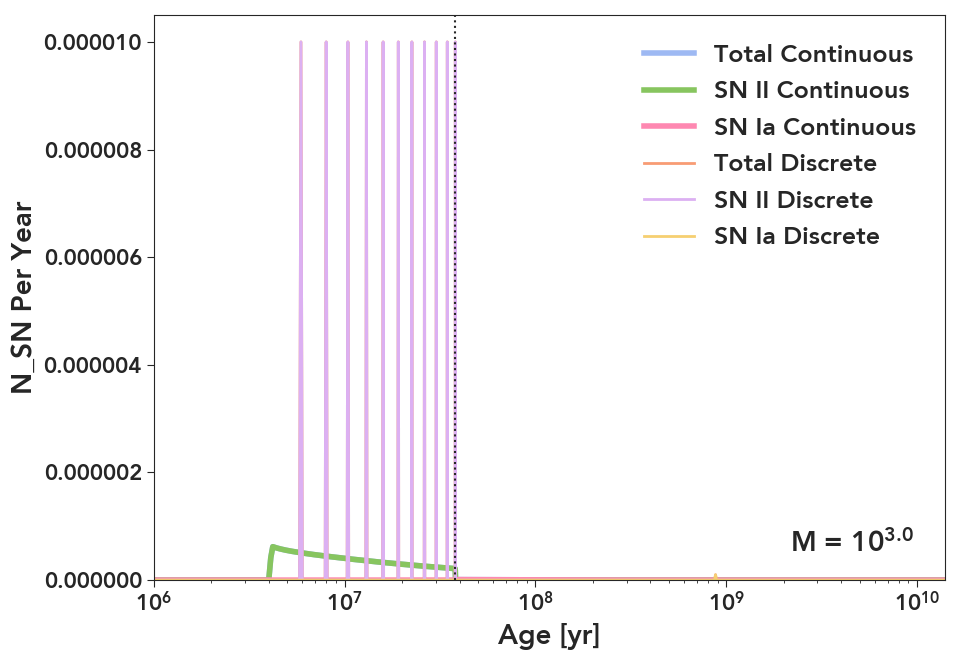

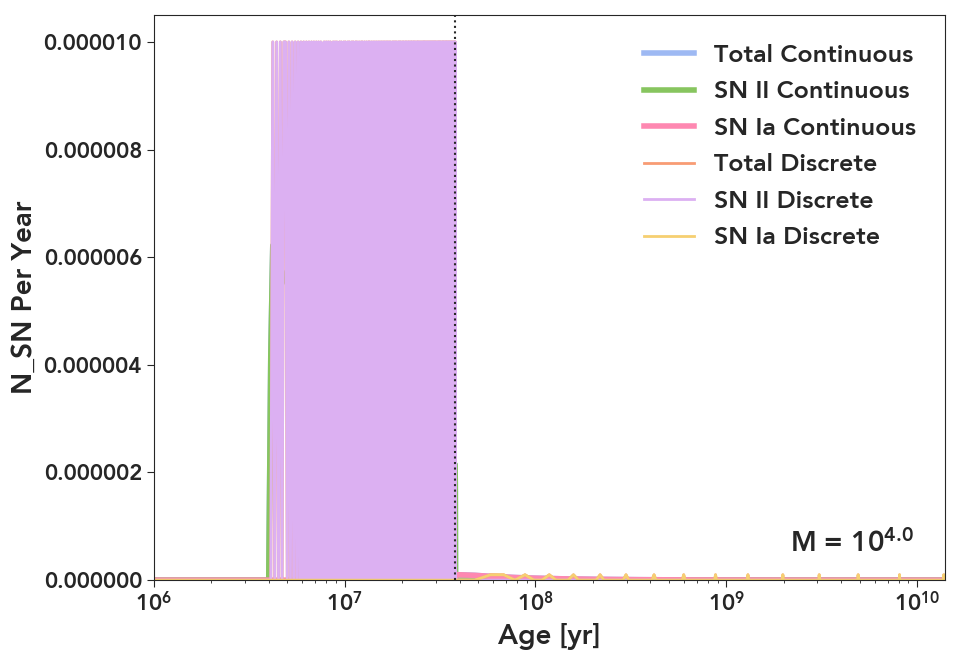

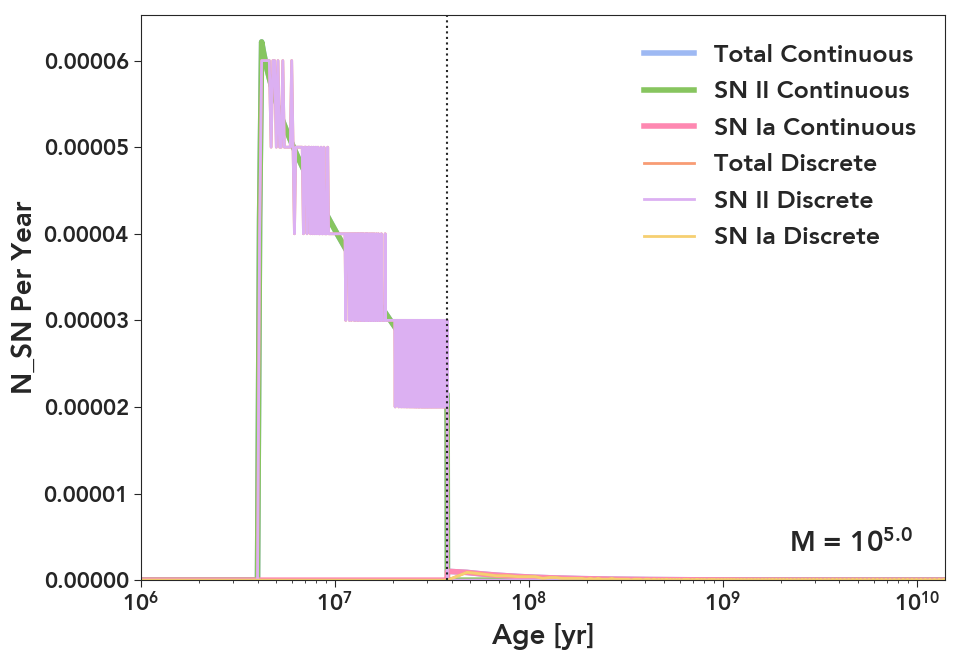

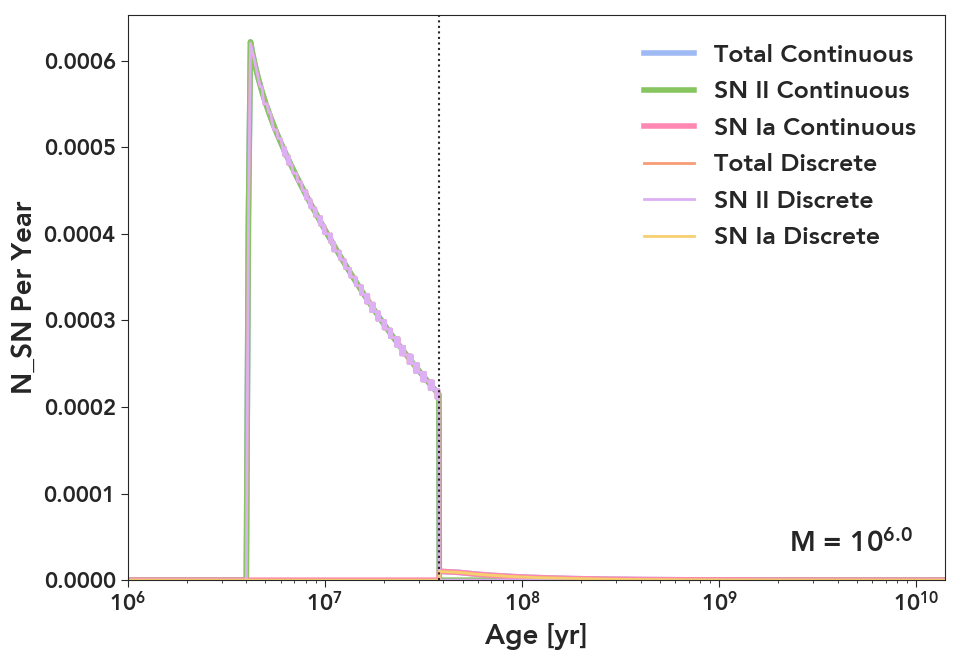

In [31]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_rates("N_SN", m, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


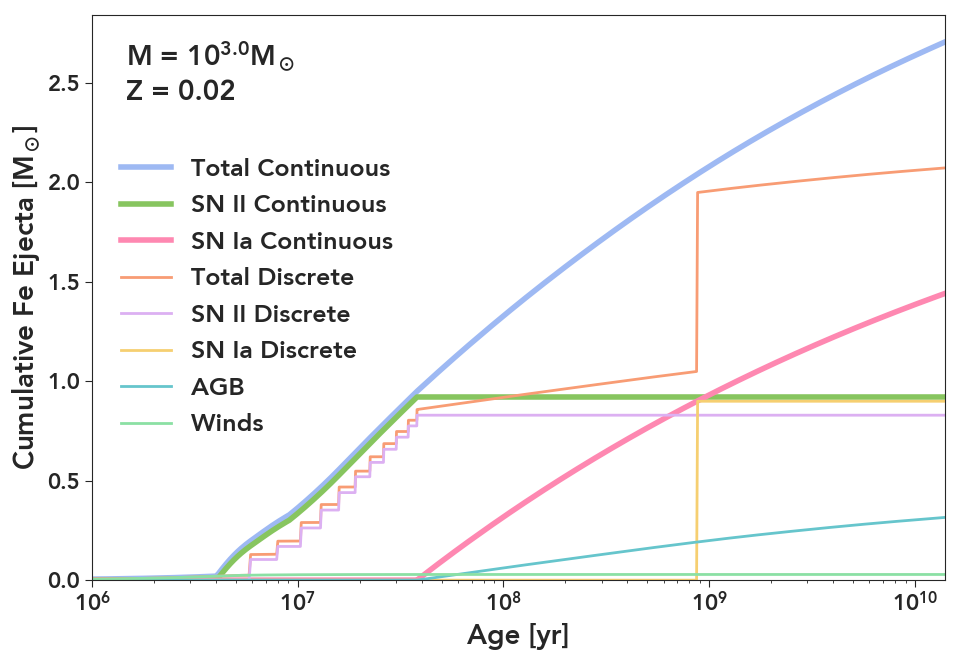

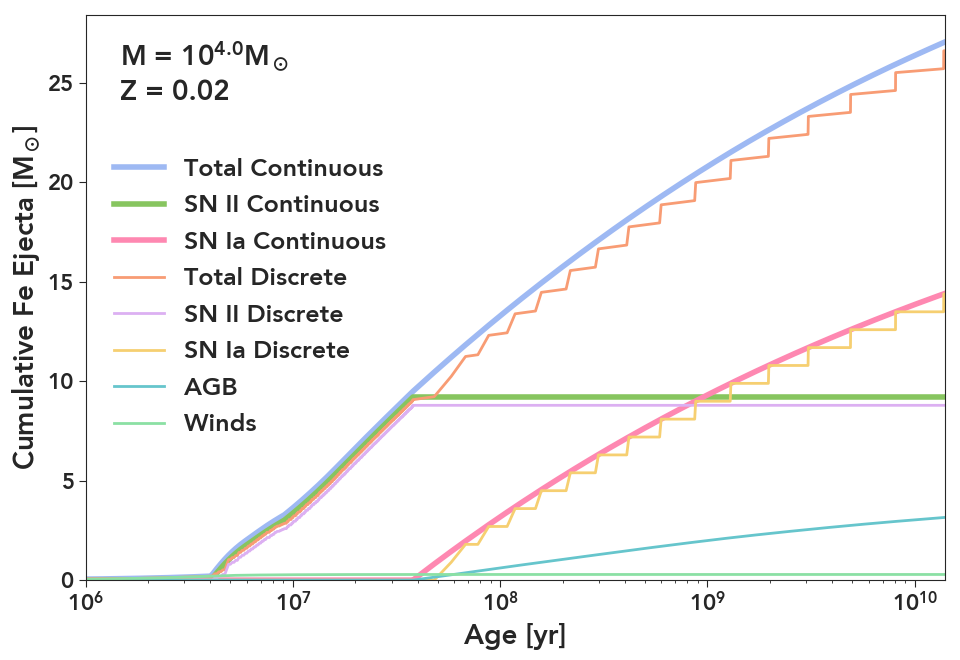

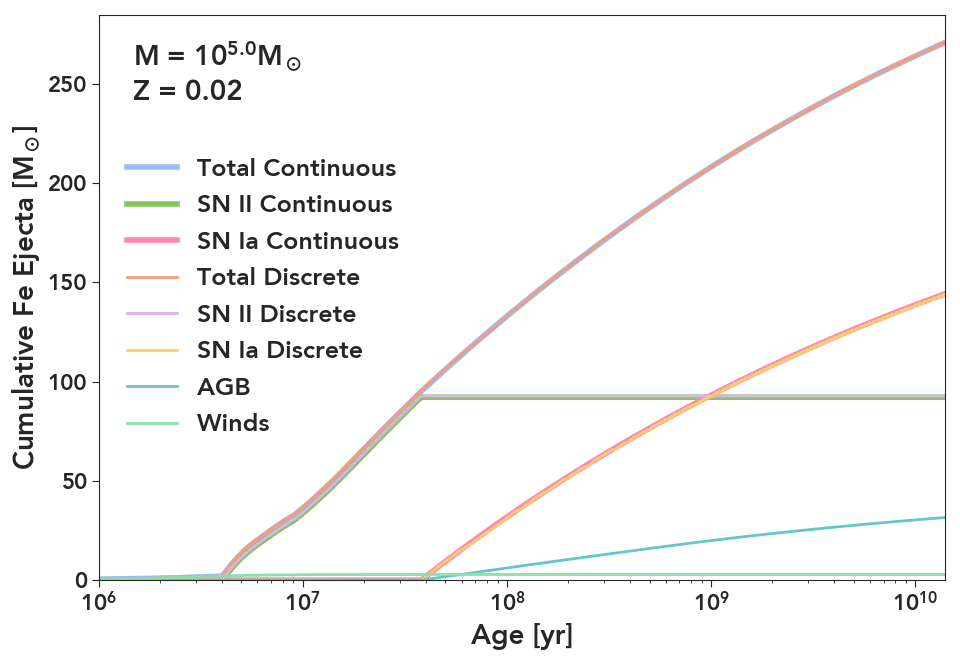

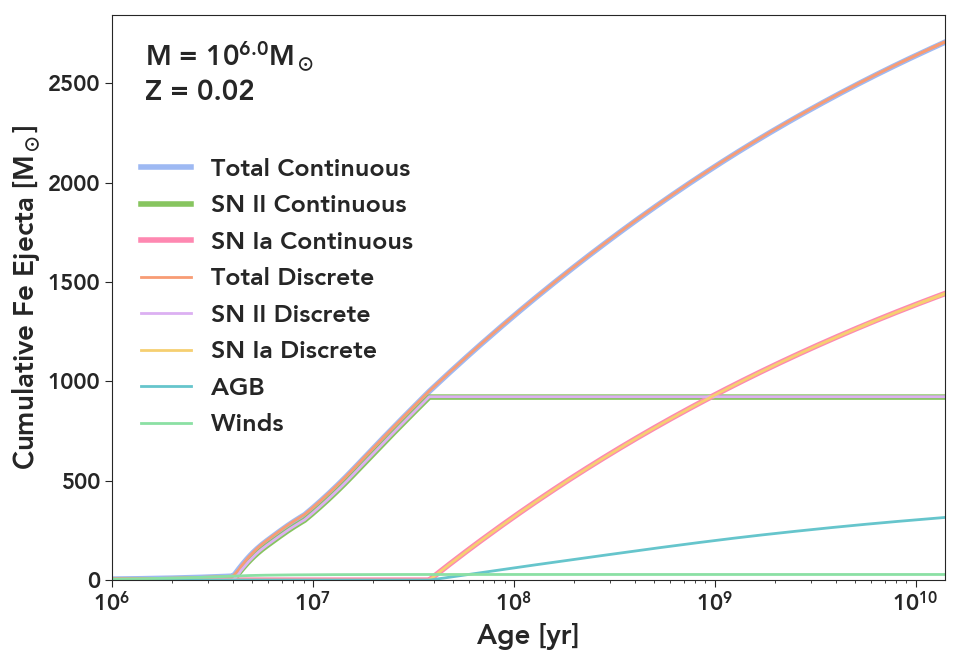

In [32]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("Fe", m, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


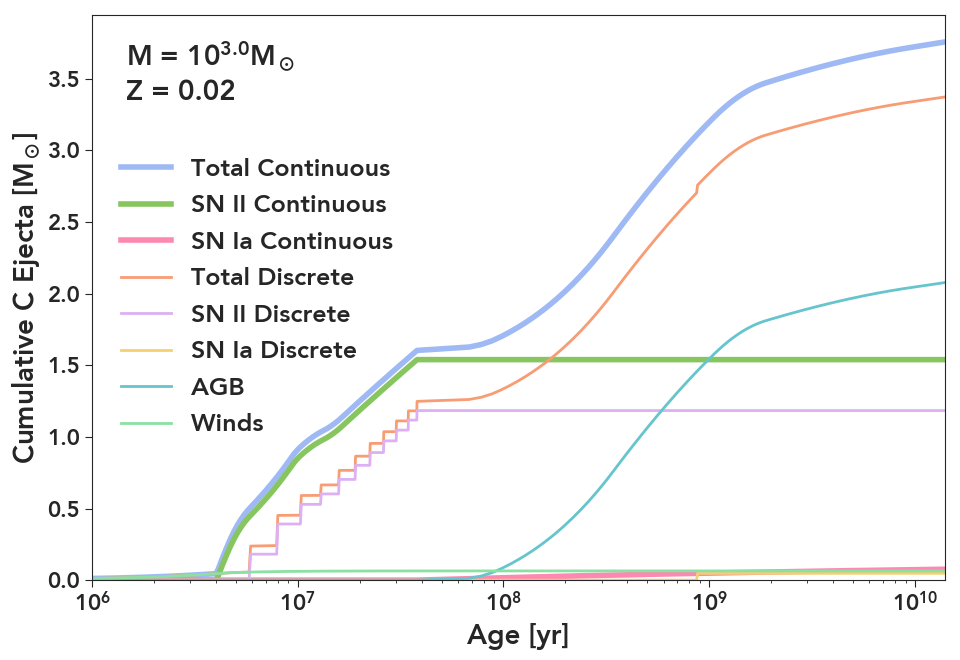

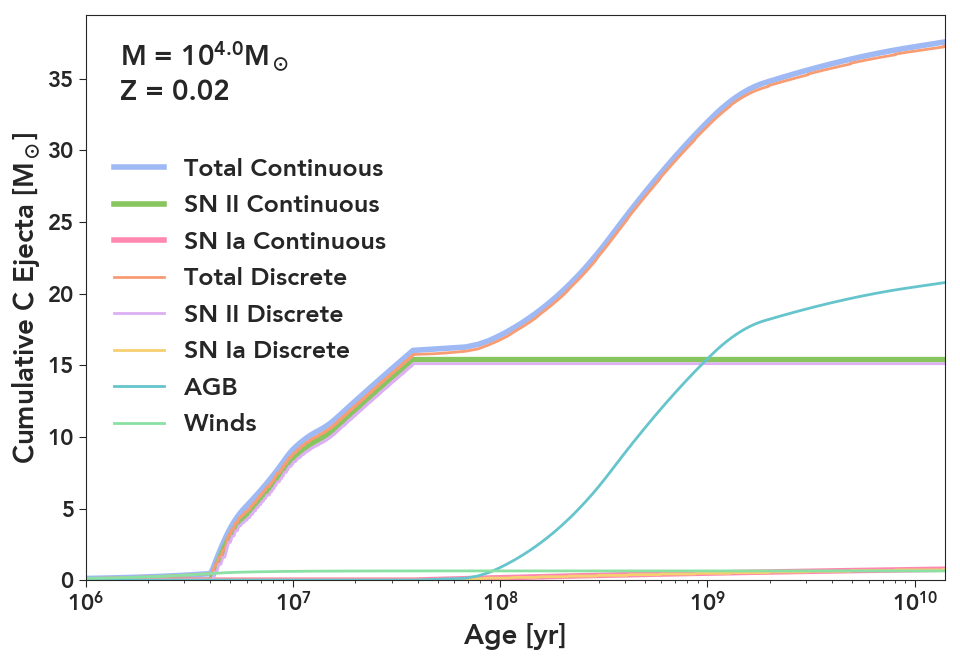

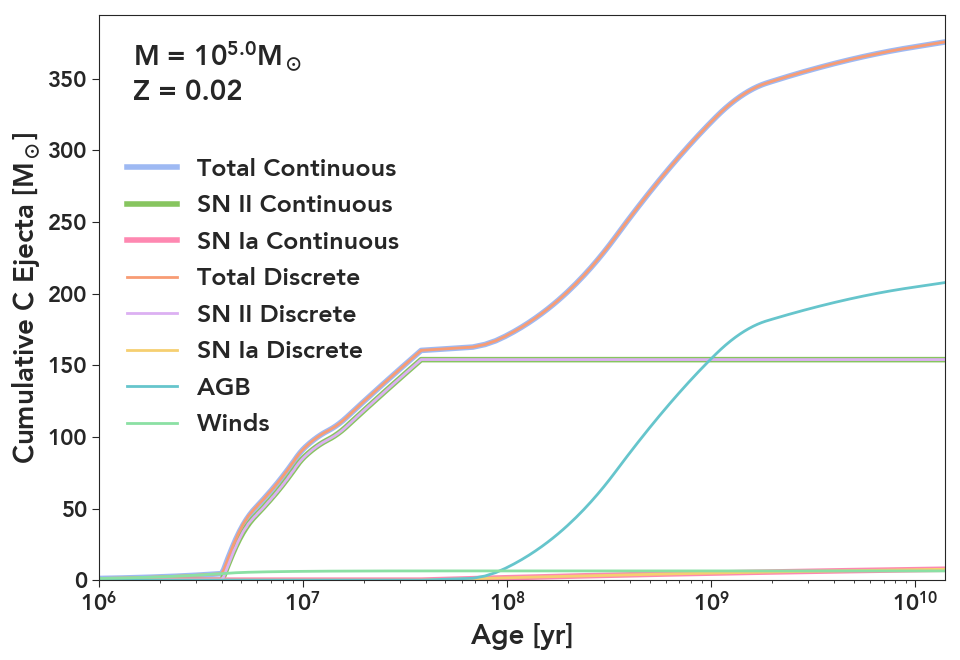

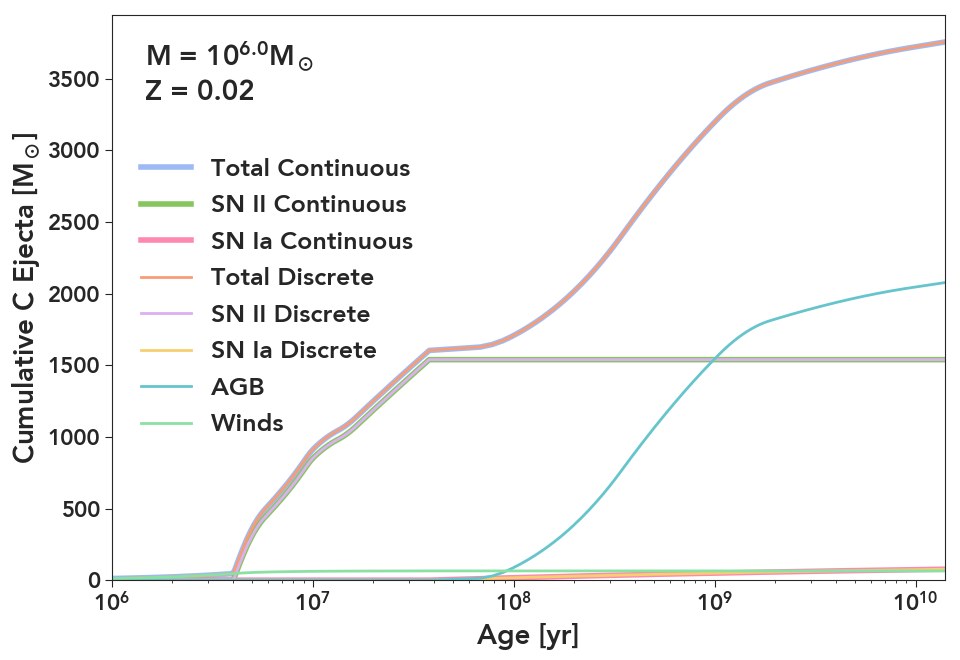

In [33]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("C", m, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


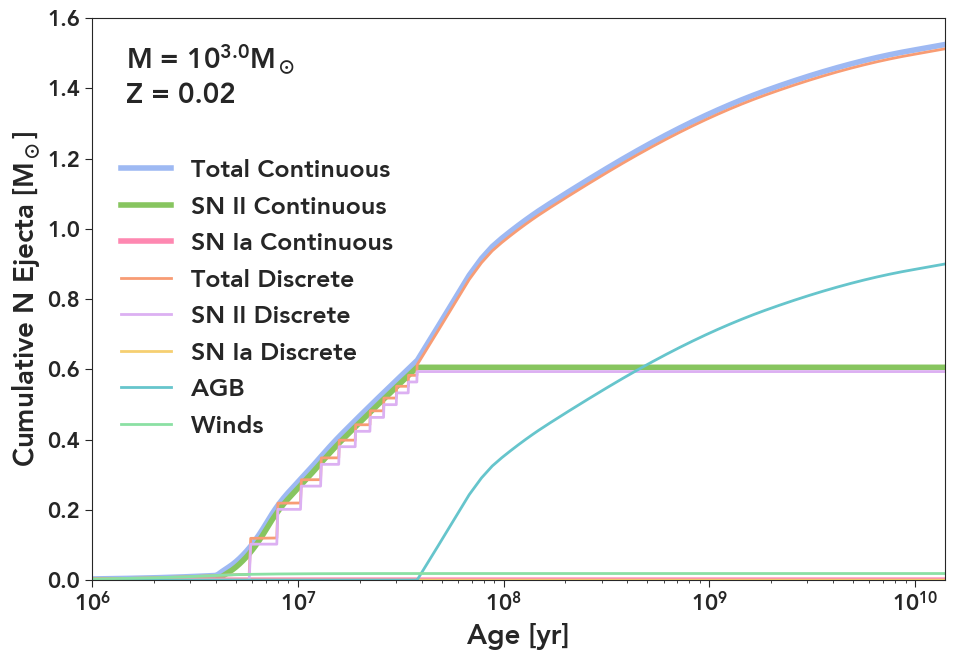

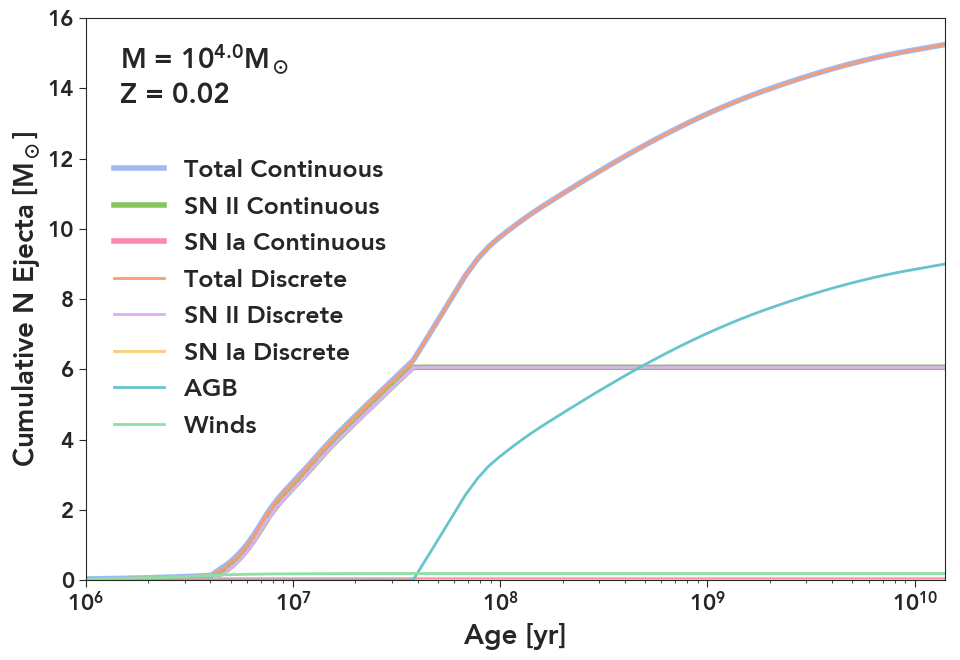

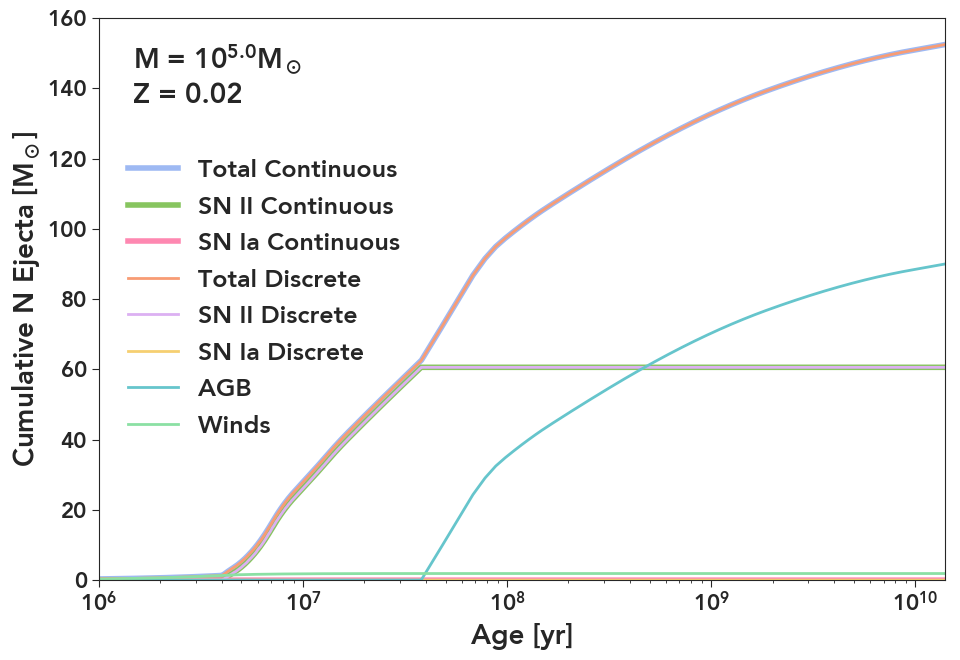

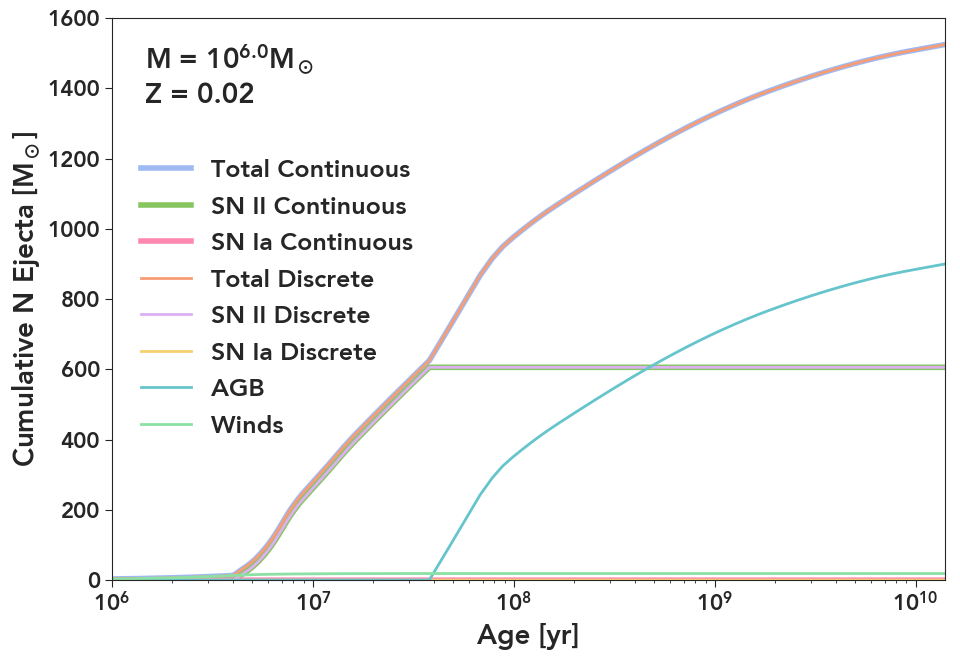

In [34]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("N", m, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


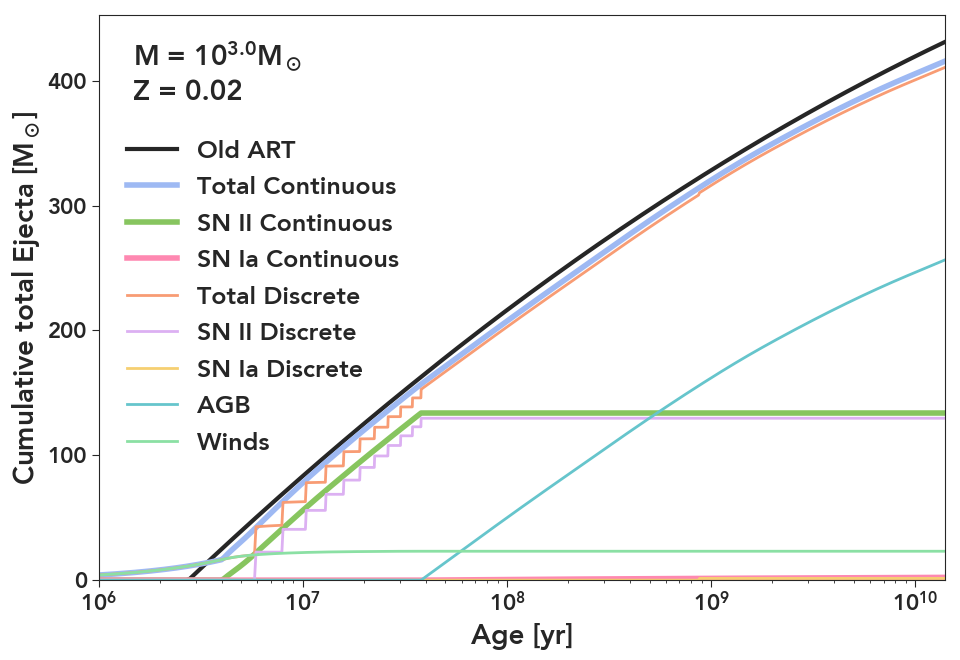

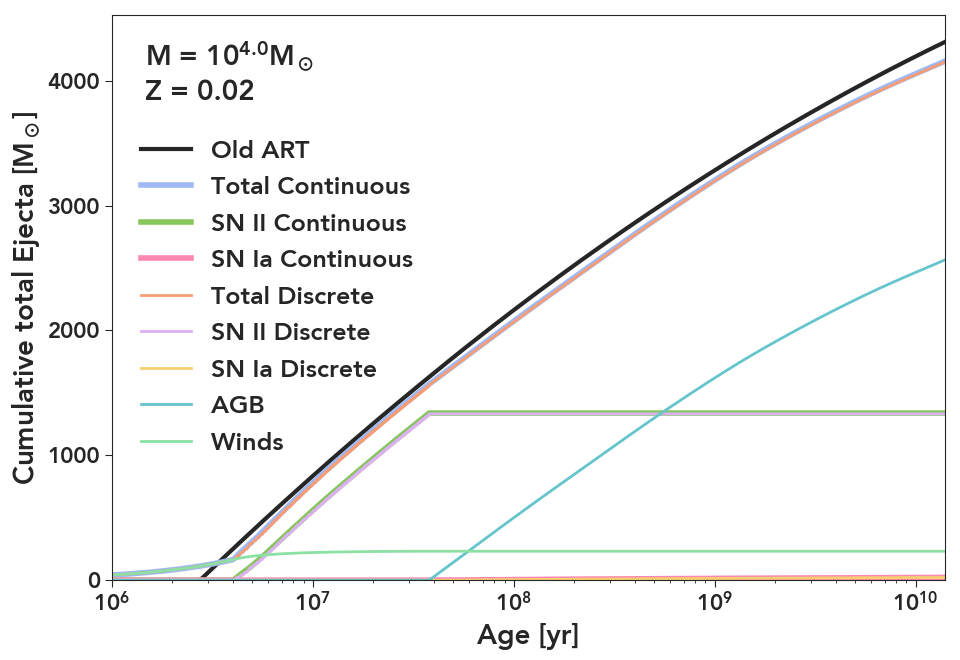

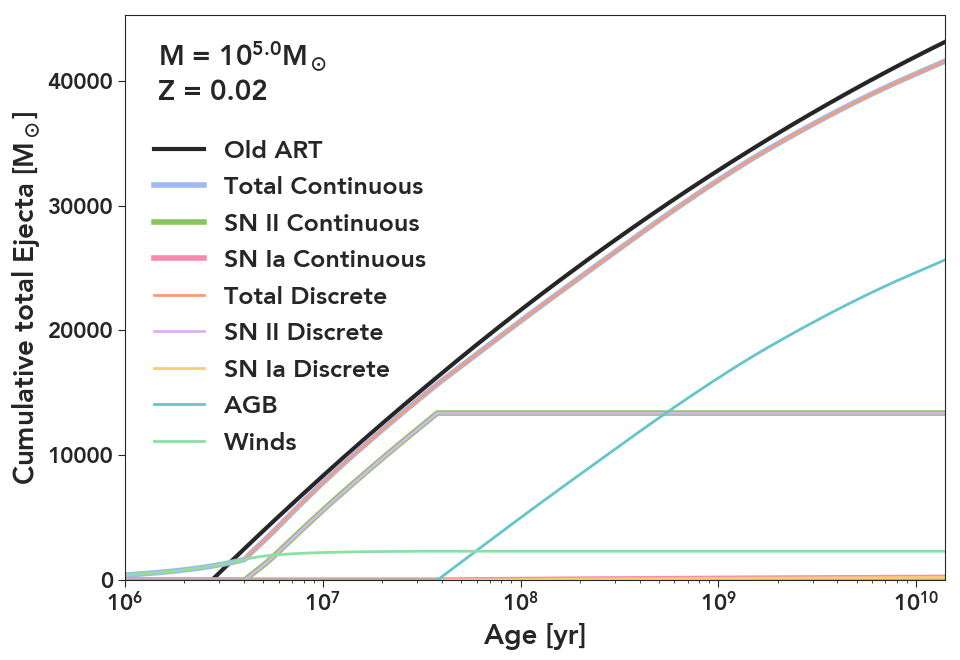

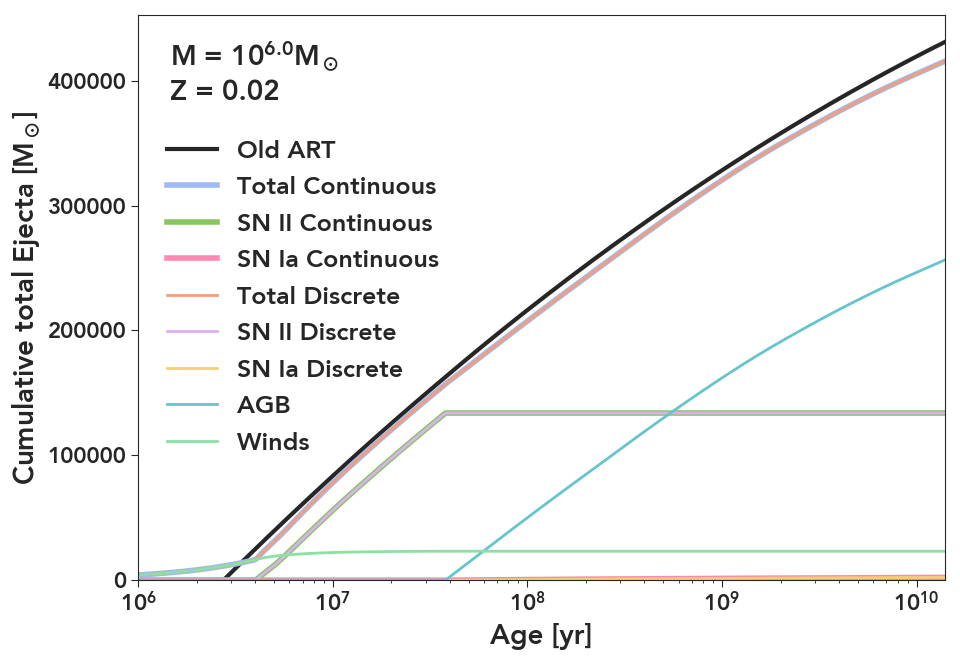

In [35]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("total", m, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


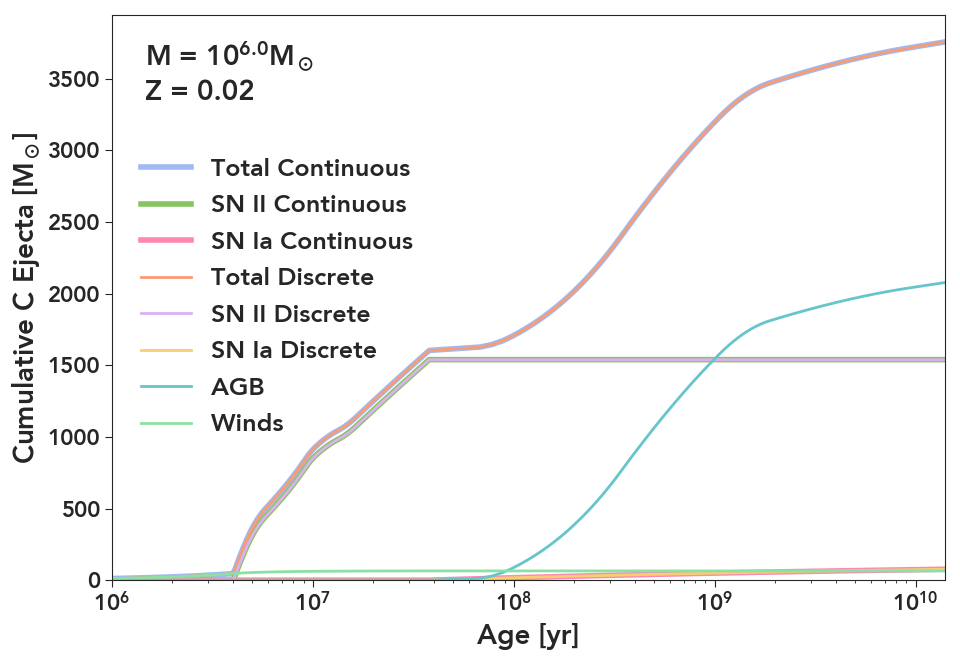

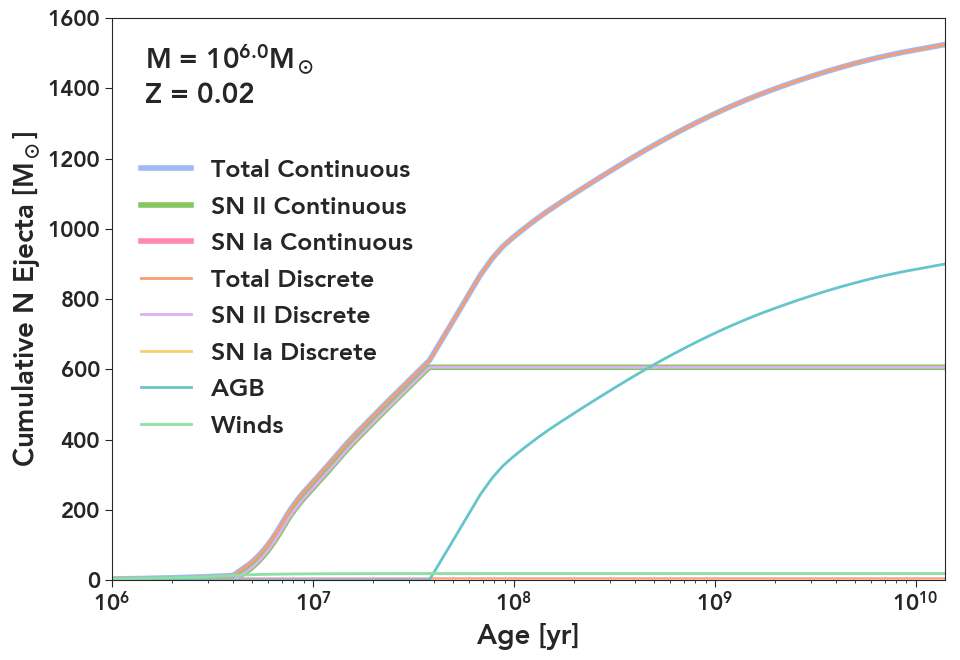

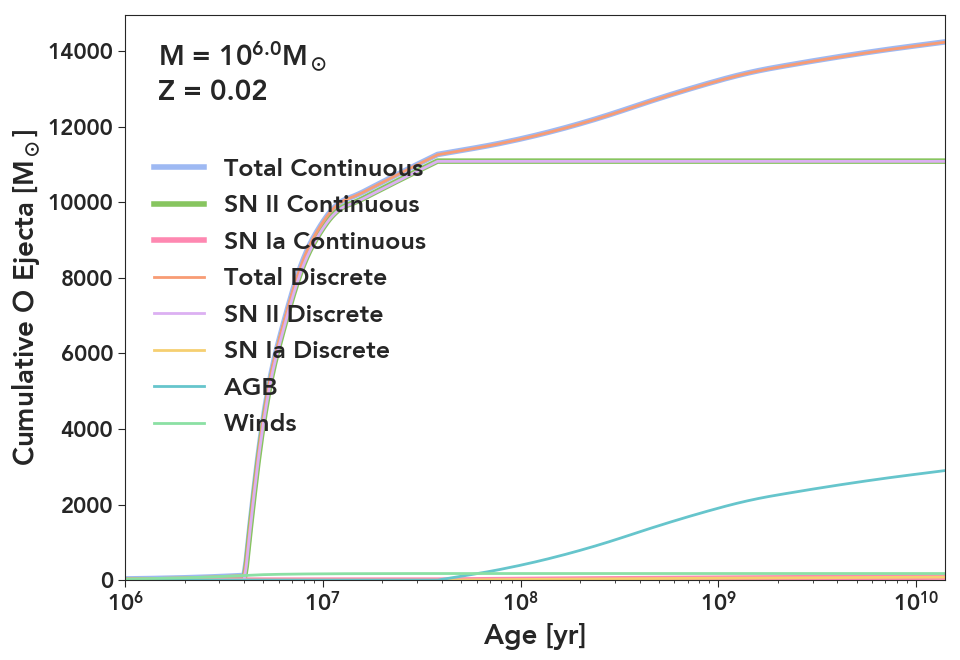

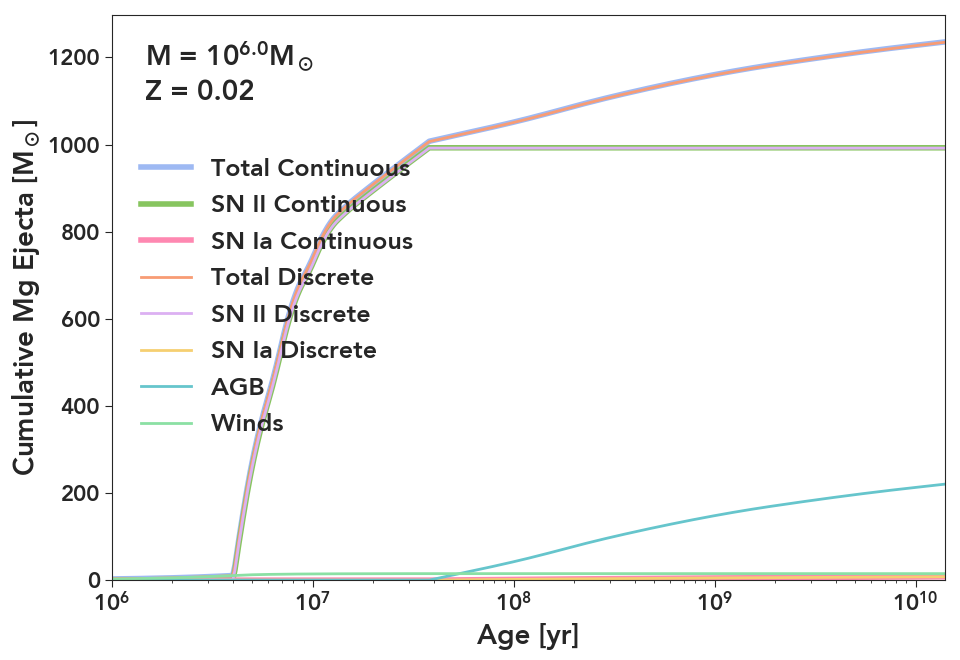

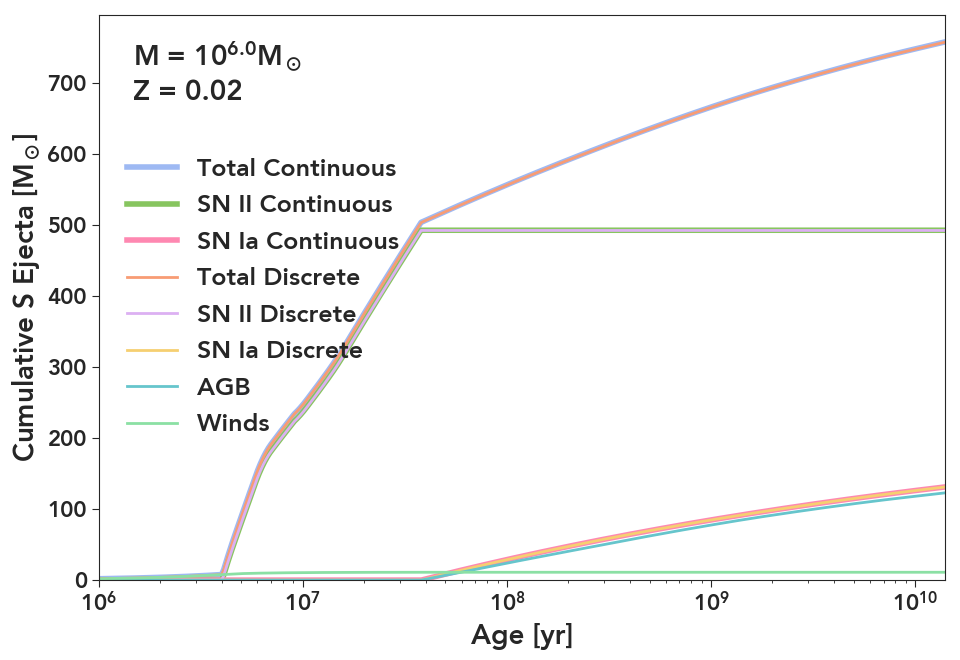

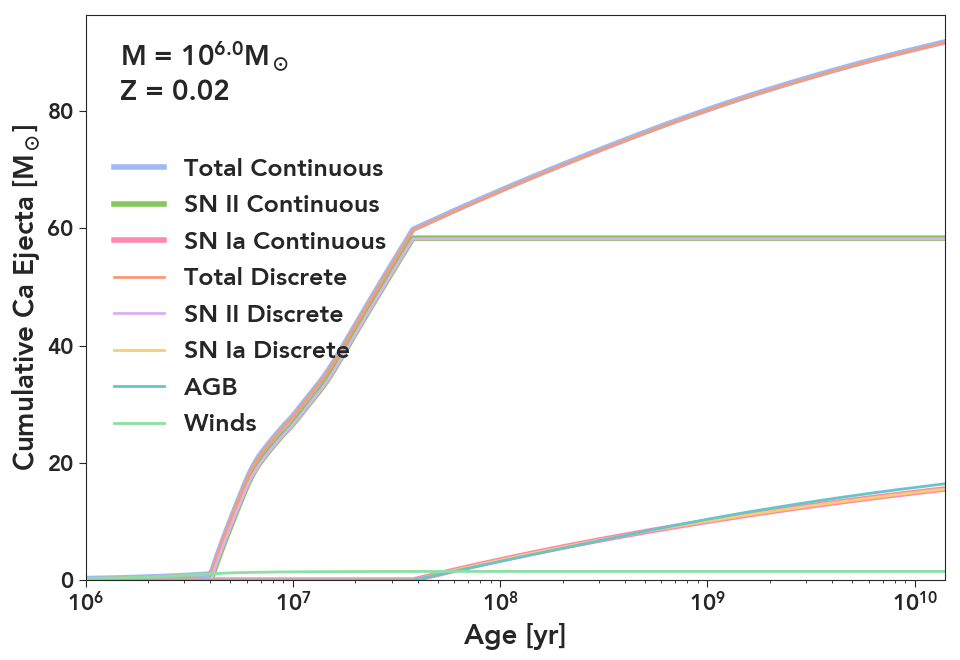

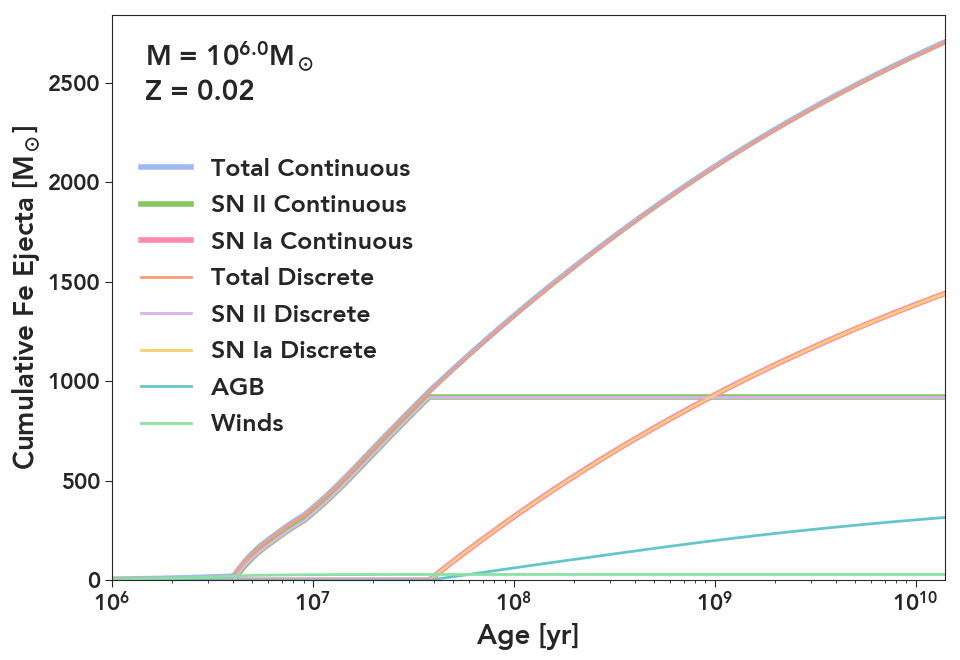

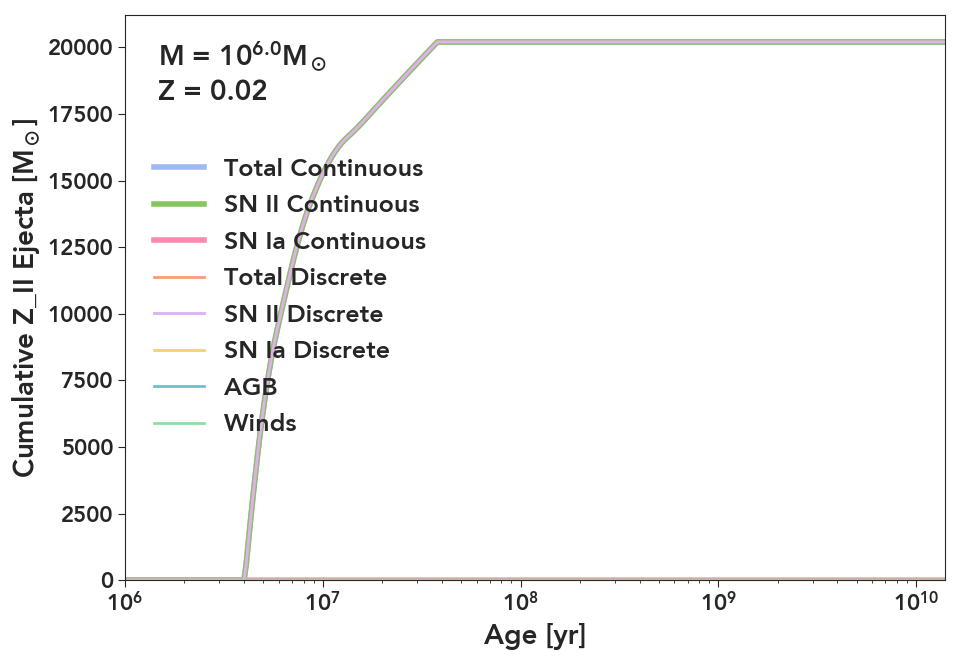

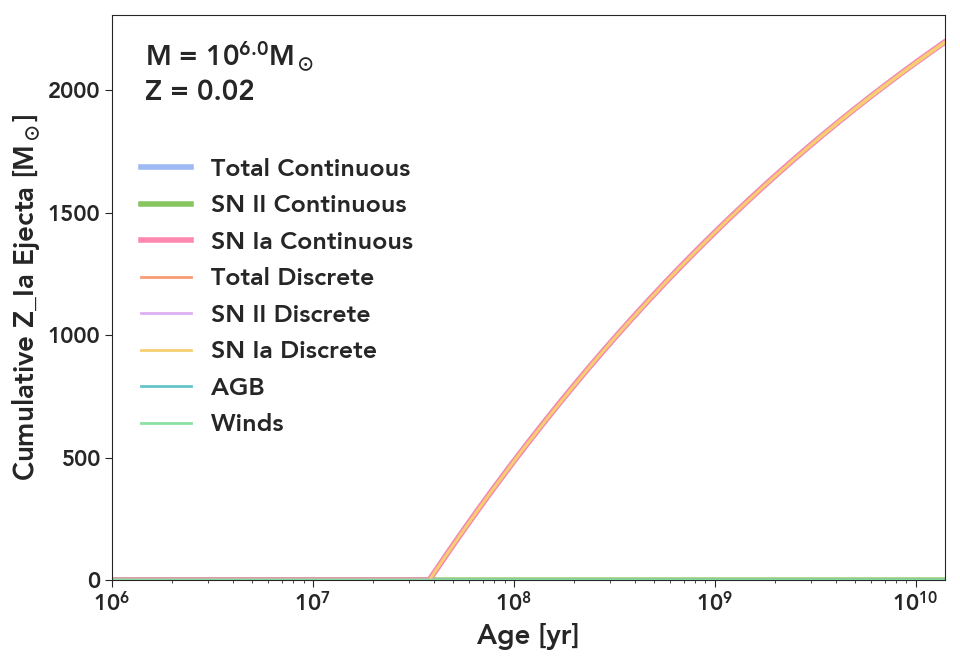

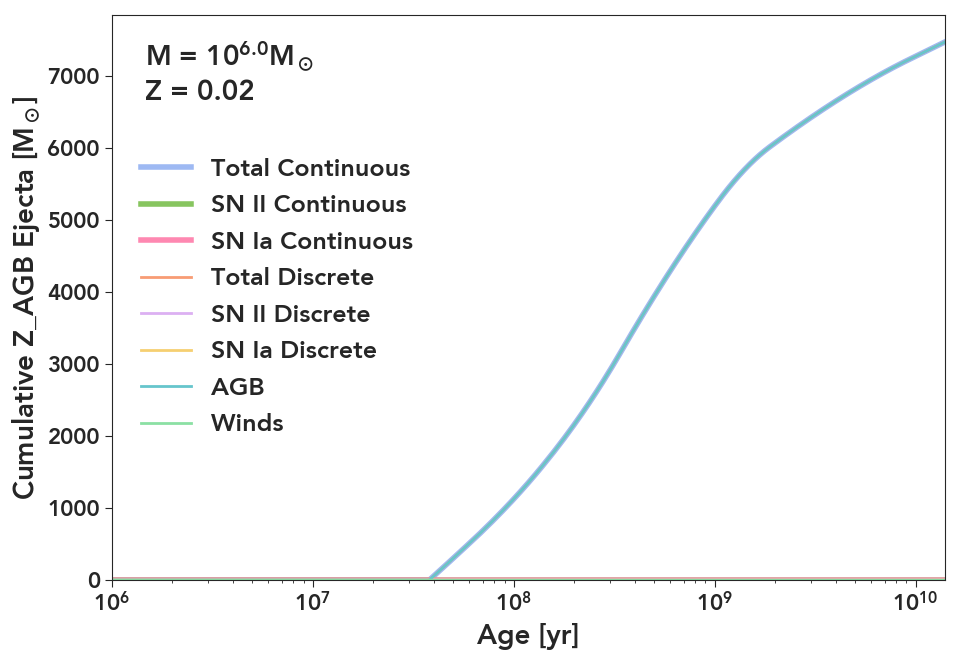

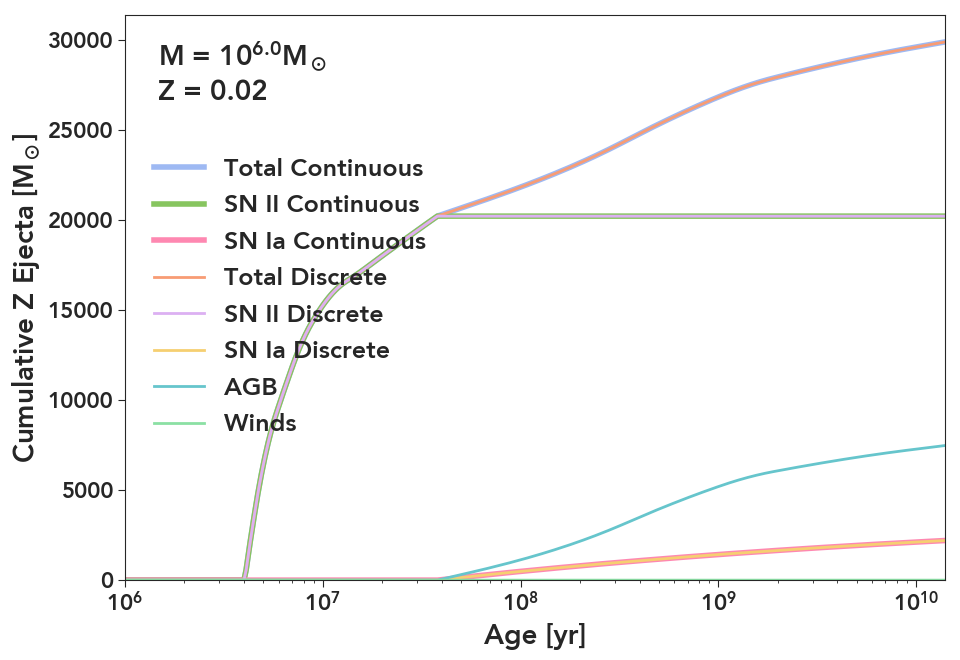

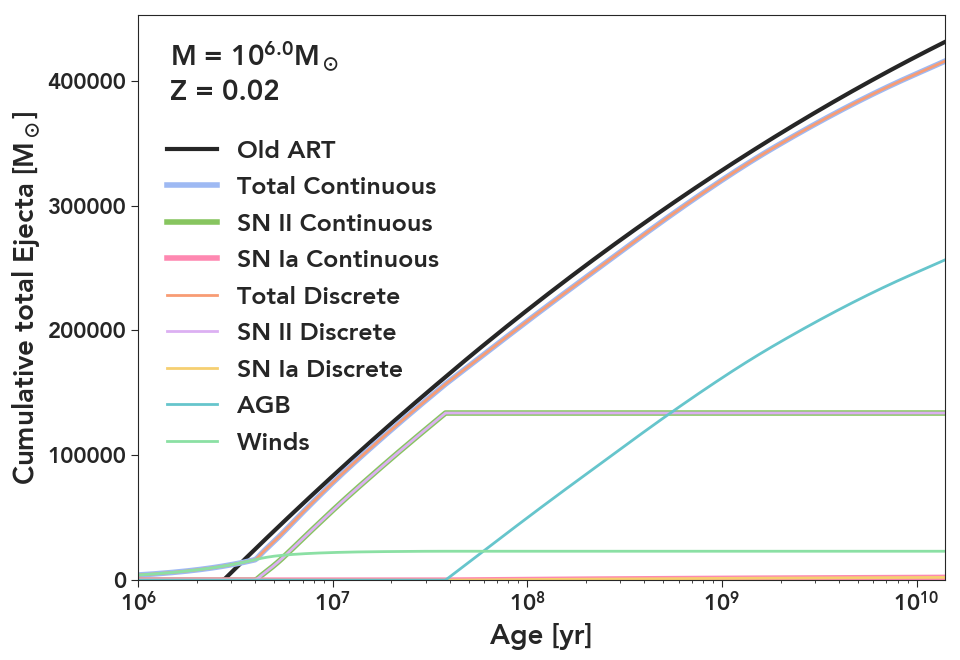

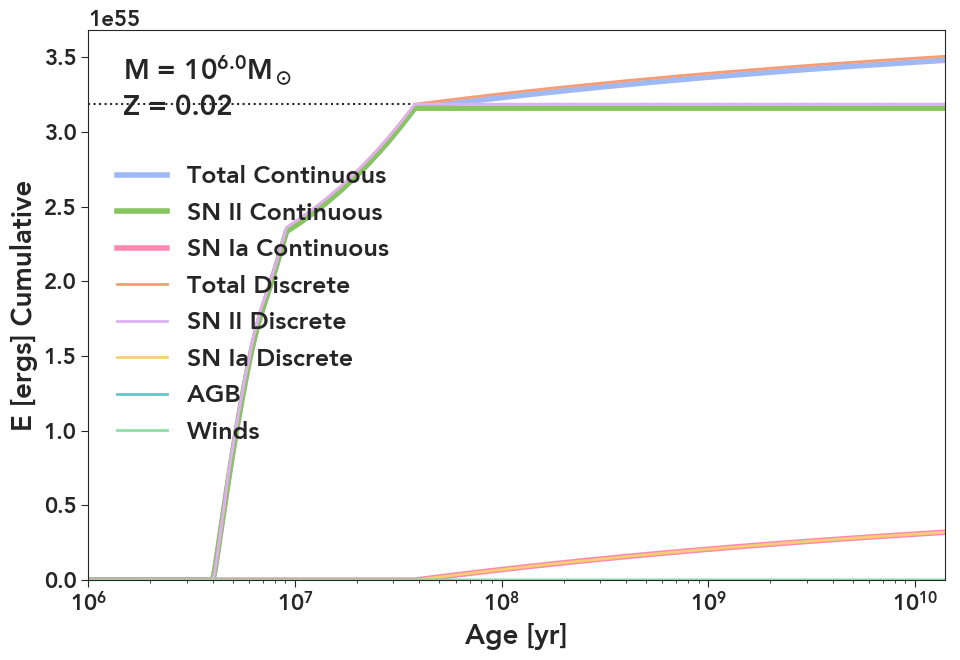

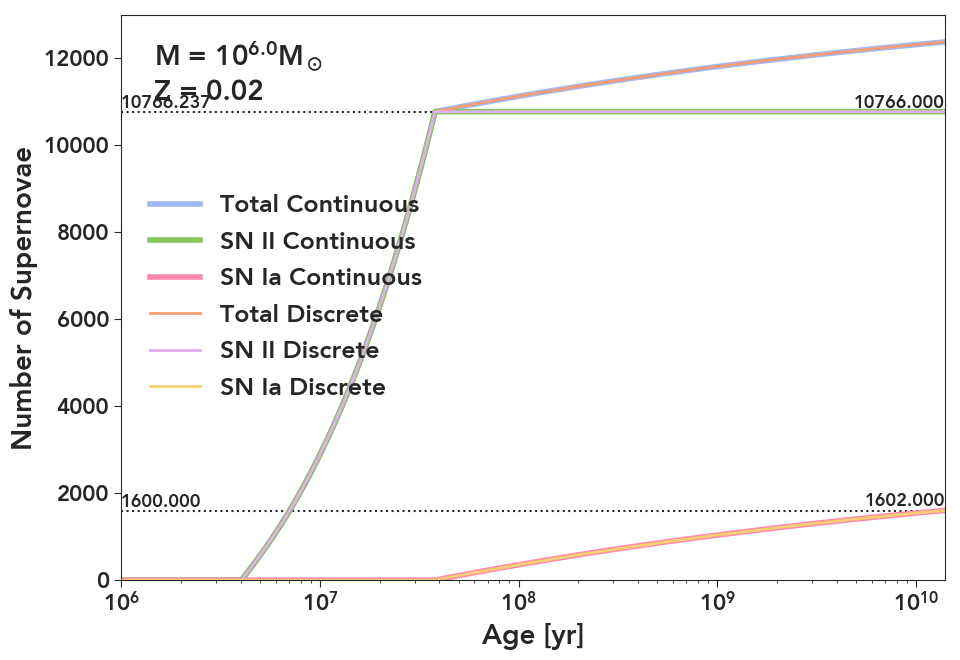

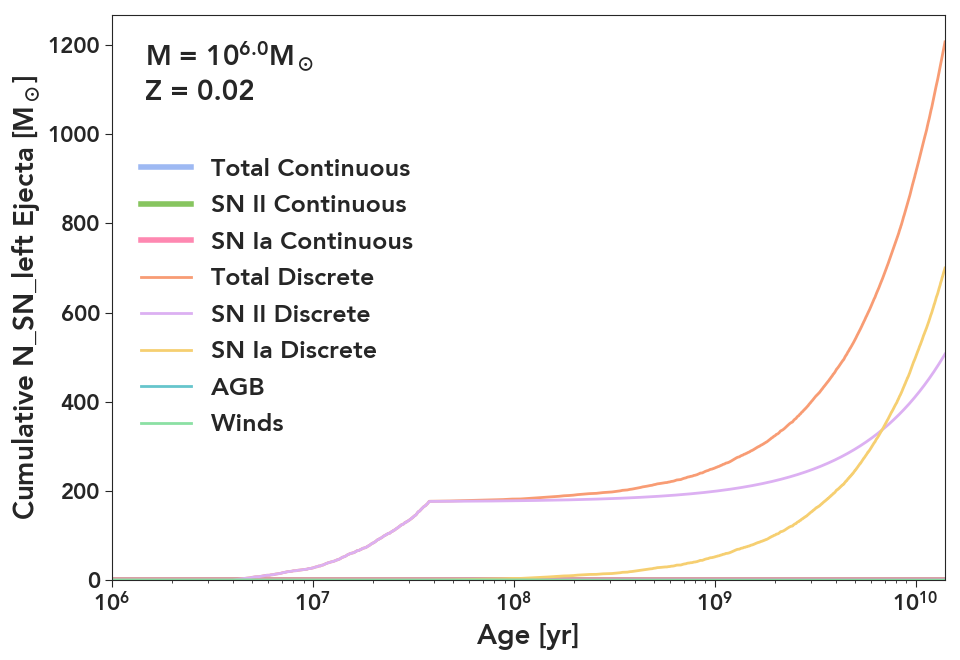

In [36]:
for elt in all_fields:
    plot_history(elt, 1E6, 0.02)

(<Figure size 1000x700 with 1 Axes>,
 <matplotlib.axes._subplots.Axes_bplSubplot at 0x1a1aa3e4e0>)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


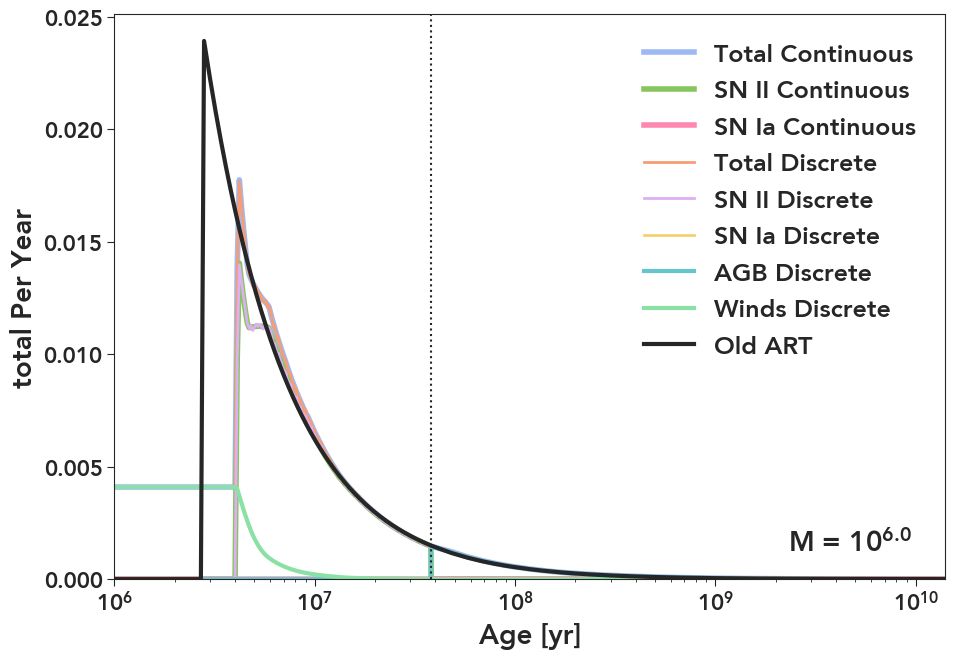

In [37]:
plot_rates("total", 1E6, 0.02)

(<Figure size 1000x700 with 1 Axes>,
 <matplotlib.axes._subplots.Axes_bplSubplot at 0x1a192ed6a0>)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


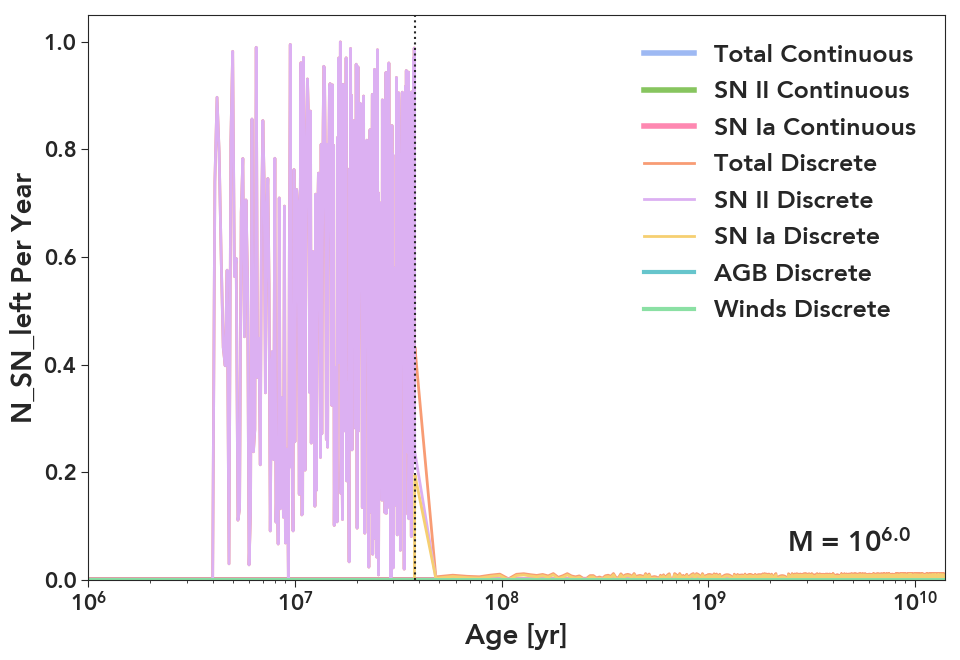

In [38]:
plot_rates("N_SN_left", 1E6, 0.02)

## Compare to previous ART prescription

In [39]:
"""
number_SNII = integrate( imf->f, snII.min_mass, snII.max_mass, 1e-6, 1e-9 );
snII_phys.number = number_SNII/(constants->Msun*total_mass);
snII_code.number = snII_phys.number*units->mass;

phi = dt/tage;
N_SN = phi*star_initial_mass[ipart] * snII_code.number;

"""


'\nnumber_SNII = integrate( imf->f, snII.min_mass, snII.max_mass, 1e-6, 1e-9 );\nsnII_phys.number = number_SNII/(constants->Msun*total_mass);\nsnII_code.number = snII_phys.number*units->mass;\n\nphi = dt/tage;\nN_SN = phi*star_initial_mass[ipart] * snII_code.number;\n\n'

In [40]:
sn_low = 3E6
sn_high = 1.5E7 + 3E6

old_number_snii = frac_N_SN_II  # calculated the same way


def old_sn_rate(age, mass):
    if age < sn_low:
        return 0
    if age > sn_high:
        return 0
    
    phi_per_dt = 1.0 / age
    rate = phi_per_dt * mass * old_number_snii
    return rate

def old_sn_energies(age, mass):
    return 1E51 * old_sn_rate(age, mass)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


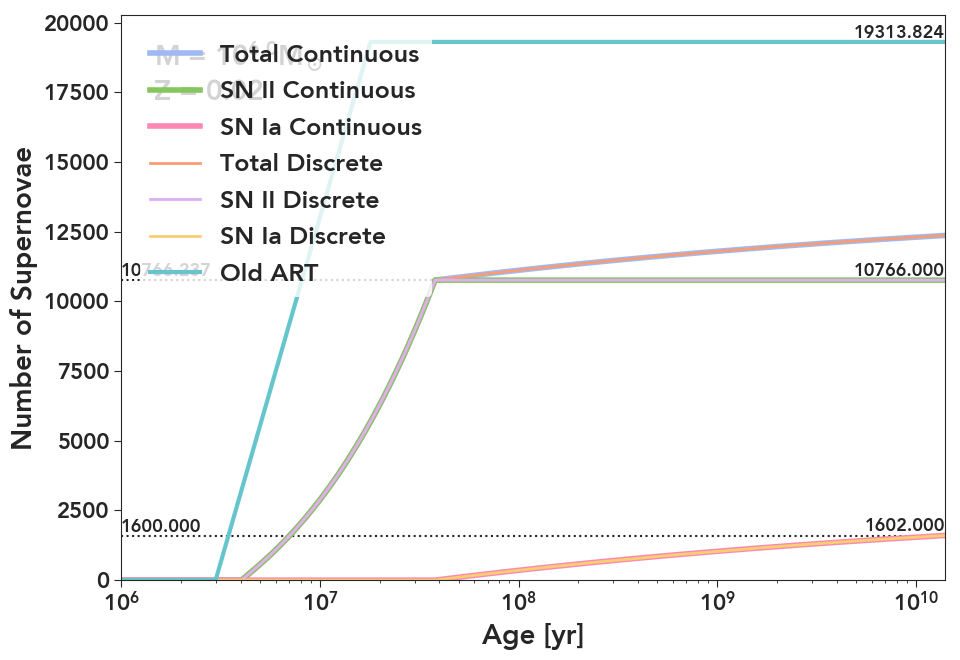

In [41]:
for m in [1E6]:
    fig, ax = plot_history("N_SN", m, 0.02)
    
    old_ages = np.logspace(6, 10.3, 1000)
    old_sn_rates = [old_sn_rate(a, m) for a in old_ages]
    old_sn_cum = integrate.cumtrapz(x=old_ages, y=old_sn_rates, initial=0)
    
    ax.plot(old_ages, old_sn_cum, label="Old ART")
    ax.add_text(14E9, old_sn_cum[-1], "{:.3f}".format(old_sn_cum[-1]), 
                ha="right", va="bottom", fontsize=13)
    
    ax.legend()
    ax.set_limits(y_max=max(old_sn_cum)*1.05)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


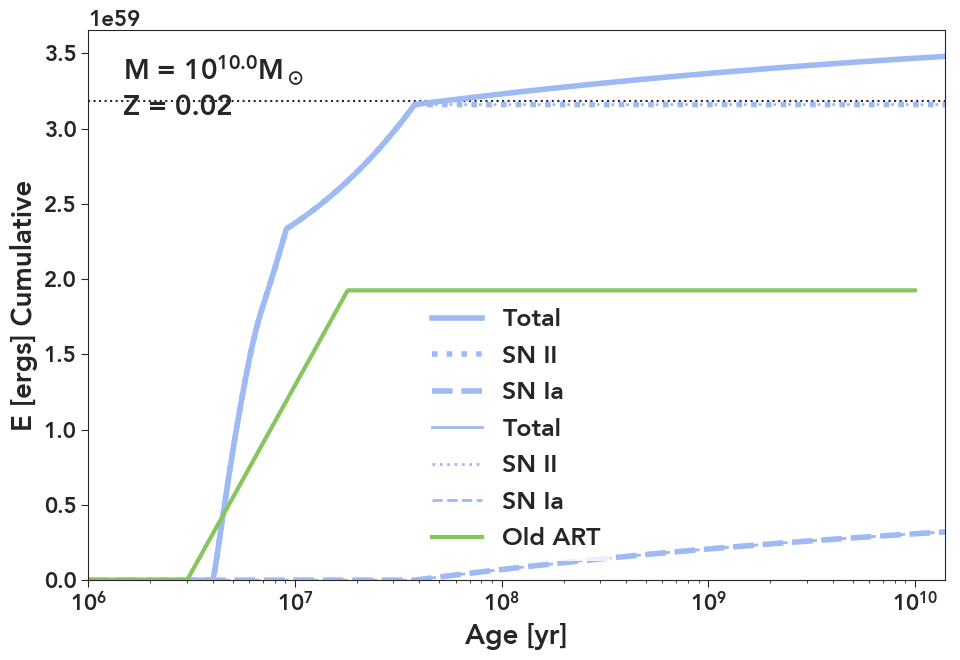

In [42]:
for m in [1E10]:
    fig, ax = plot_history_energy(m, 0.02, 1)
    
    old_ages = np.logspace(6, 10, 1000)
    old_e_rates = [old_sn_energies(a, m) for a in old_ages]
    old_e_cum = integrate.cumtrapz(x=old_ages, y=old_e_rates, initial=0)
    
    ax.plot(old_ages, old_e_cum, label="Old ART", c=bpl.color_cycle[1])
    
    ax.legend()
#     ax.set_limits(y_max=max(old_e_cum)*1.05)

NameError: name 'ages' is not defined

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


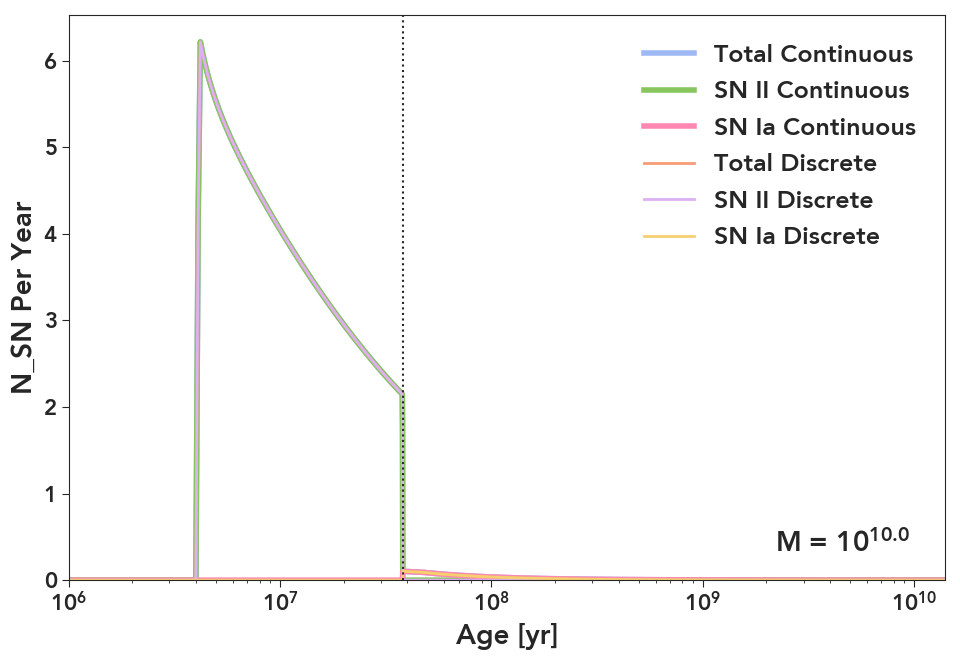

In [43]:
for m in [1E10]:
    fig, ax = plot_rates("N_SN", m, 0.02)
    
    old_ages = np.logspace(6, 8, 1000)
    old_sn_rates = [old_sn_rate(a, m) for a in ages]
    
    ax.plot(old_ages, old_sn_rates, label="Old ART")
    
    ax.legend()
    ax.set_limits(y_max=1.05*max(old_sn_rates))

In [ ]:
for m in [1E10]:
    fig, ax = plot_rates("E", m, 0.02)
    
    old_ages = np.logspace(6, 8, 1000)
    old_e_rates = [old_sn_energies(a, m) for a in ages]
    
    ax.plot(old_ages, old_e_rates, label="Old ART")
    
    ax.legend()

# Yields

In [ ]:
from matplotlib import colors
from matplotlib import cm

In [ ]:
def yield_agb_wrapper(z, m, elt):
    if elt == "Z":
        raw_z_yield = core.get_yields_raw_agb_py(z, m)[agb_idxs_yields["Z_AGB"]]
        ca_yield = yield_agb_wrapper(z, m, "Ca")
        s_yield = yield_agb_wrapper(z, m, "S")
        fe_yield = yield_agb_wrapper(z, m, "Fe")
        return raw_z_yield + ca_yield + s_yield + fe_yield
    
    # implicit else
    if elt in ["S", "Ca", "Fe"]:
        return (z / 0.02) * solar_metallicities[elt] * core.get_yields_raw_agb_py(z, m)[agb_idxs_yields["total"]]
    
    # implicit else
    return core.get_yields_raw_agb_py(z, m)[agb_idxs_yields[elt]]

In [ ]:
norm = colors.LogNorm(vmin=1E-4, vmax=0.02)
mappable = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
mappable.set_array([])

In [ ]:
ls = {"AGB": "--", "SN": "-", "HN":":"}
lw = {"AGB": 2, "SN": 2, "HN":4}

ms = dict()
ms["AGB"] = np.arange(0.6, 8.01, 0.1)
ms["SN"] = np.arange(8.0, 50.01, 0.1)
ms["HN"] = np.arange(20.0, 50.01, 0.1)

for elt in elts + ["Z", "total"]:
    fig, ax = bpl.subplots()
    ax.add_labels("Progenitor Mass [$M_\odot$]", "Ejected Mass in {}".format(elt) + " [$M_\odot$]")
    
#     for z_idx, z in enumerate([0.0001, 0.001, 0.005, 0.01, 0.02]):
    for z_idx, z in enumerate(np.logspace(-4, np.log10(0.02), 50)):
        c = mappable.to_rgba(z)
        
        for func, label in zip([core.get_yields_raw_sn_ii_py,
                                core.get_yields_raw_hn_ii_py,
                                core.get_yields_raw_agb_py], 
                                   ["SN", "HN", "AGB"]):
            if label == "AGB":
                yields = [yield_agb_wrapper(z, m, elt) for m in ms[label]]
            else:
                yields = [func(z, m)[sn_ii_idxs[elt]] for m in ms[label]]



            if z_idx > 0:
                plot_label=None
            else:
                plot_label=label
            ax.plot(ms[label], yields, label=plot_label, ls=ls[label], lw=lw[label], c=c)
    
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    cbar = fig.colorbar(mappable)
    cbar.set_label("Metallicity")
    ax.legend()

# SN rates

In [ ]:
rates = [snia_discrete_elts.get_sn_ia_rate_py(t, lt.lifetime(8.0, 0.02)) for t in times[0.02]]

In [ ]:
fig, ax = bpl.subplots()
ax.plot(times[0.02], rates)
ax.set_xscale("log")
ax.set_yscale("log")
ax.add_labels("Time [yr]", "SN Ia rate [SN year$^{-1}$ M$^{-1}_\odot$]")

In [ ]:
test_times = np.arange(0, 1E10, 1E3)
for func in [snia_discrete_elts.sn_ia_core_py,
             snia_discrete_no_elts.sn_ia_core_py,
             snia_continuous_elts.sn_ia_core_py,
             snia_continuous_no_elts.sn_ia_core_py]:
    for t in tqdm(test_times):
        func(0.1, t, dt_sn, 1E6, 0.02, 40E6)

In [ ]:
test_times = np.arange(0, 1E10, 1E3)
for func in [snii_discrete_elts.get_ejecta_sn_ii_py,
             snii_discrete_no_elts.get_ejecta_sn_ii_py,
             snii_continuous_elts.get_ejecta_sn_ii_py,
             snii_continuous_no_elts.get_ejecta_sn_ii_py]:
    for t in tqdm(test_times):
        func(0.1, 12, 8.1, 1E6, 0.02)

In [ ]:
test_times = np.arange(0, 1E10, 1E3)
for t in tqdm(test_times):
    agb_elements.get_ejecta_agb_py(34, 6, 1E6, 0.02, 1E-5, 1E-5, 1E-5)

In [ ]:
for elts in ["C", "O", "Z", "total", "N_SN"]:
    print(snii_discrete_elts.get_ejecta_sn_ii_py(0, 53, 42, 1E6, 0.02)[sn_ii_idxs[elts]])

In [ ]:
for elts in ["C", "O", "Z", "total", "N_SN"]:
    print(snii_continuous_elts.get_ejecta_sn_ii_py(0, 53, 42, 1E6, 0.02)[sn_ii_idxs[elts]])

In [ ]:
core.get_yields_raw_sn_ii_py(34, 0.02)

In [ ]:
core.get_yields_raw_sn_ii_py(0.02, 34)[0]

In [ ]:
n_sn = core.imf_integral_py(29.695113385786325, 29.79659090887414) * 297842.737699386

In [ ]:
m_sun_to_code = 0.24946558475494385 / 297842.737699386

In [ ]:
n_sn * m_sun_to_code**2

In [ ]:
snii_continuous_no_elts.get_ejecta_sn_ii_py(0.1, 12, 8.1, 1E6, 0.02)[0]